# Quantitative analysis
2019.04.22 - ?

In this notebook, I do some quantitative analysis with a focus on the Pitt ELI Corpus, as that has multiple L1s to compare. This notebook will look at some more quantitative features of the target languages in PELIC, such as raw and relative counts of various articles, the most common nouns following certain article conditions, and an attempt at investigating possible errors using more computational methods (as opposed to hand-done analysis).

### Index
- [Section 1](#section1), where set-up occurs
- [Section 2](#section2), where a bit of modification occurs
- [Section 3](#section3), where analysis is done
- [Section 4](#conclusion), with my concluding thoughts

<a id='section1'></a>
## First Section
- Set up:
    - importing libraries, opening files, the like

In [1]:
import pandas as pd
import numpy as np
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [3]:
# PELIC - will need to be filtered a bit
f = open('/Users/elenacimino/Data-Archive/combo_df_1A_pt1.pkl', 'rb')
data = pickle.load(f)
f.close()

target_langs = ['Arabic', 'Korean', 'Spanish']
filters = (data.native_language.isin(target_langs)) & \
          (data.version == 1) & (data.level_id >= 3) & \
          (data.class_code == 'w')

# apply filters to data to get target data
pelic = data[filters]

pelic.sample(5)

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk
answer_id,,,,,,,,,,,
37654,4891,aw4,80311,Movies That I Like\n\n Movies are beautifu...,w,3,Arabic,1,"[movies, that, i, like, movies, are, beautiful...",314,"[Movies, That, I, Like, Movies, are, beautiful..."
37704,4893,gi1,80437,"Photograghers say "" A picture can convey a mes...",w,4,Arabic,1,"[photograghers, say, a, picture, can, convey, ...",451,"[Photograghers, say, ``, A, picture, can, conv..."
16976,2367,co4,38015,"Jealousy, treachery and difficult life are som...",w,5,Arabic,1,"[jealousy, treachery, and, difficult, life, ar...",16,"[Jealousy, ,, treachery, and, difficult, life,..."
8531,1250,bu4,25901,"3 support points\nStop my own job – money, tim...",w,4,Korean,1,"[support, points, stop, my, own, job, money, t...",559,"[3, support, points, Stop, my, own, job, –, mo..."
10670,1516,bi6,27641,University of Pittsburgh has a good English la...,w,5,Arabic,1,"[university, of, pittsburgh, has, a, good, eng...",593,"[University, of, Pittsburgh, has, a, good, Eng..."


<a id='section2'></a>
## Section 2
There's a bit of modification here, including: 
- [1](#gui) Adding Guiraud's R to PELIC data
- [2](#pos) POS-tagging PELIC with spaCy
- Coding of each nominal object in a text, which is broken down into two parts:
    - [3](#coding) Explanation of coding every noun that occurs in documents for several features using `findArticles`
    - [4](#funct) The actual function `findArticles` and application to the dataset
- [5](#features) Using returns from `findArticles` to get counts of different types of nouns
- [6](#apply) Applying functions that will return the tokens and counts for different (broad) article usages
- [7](#errors) Applying functions that will return the tokens and counts for finer-tuned article usages that may inform about speakers' errors or avoidance
    - Specifically, looking at the articles in front of common nouns
- [8](#ratios) Noun ratios (noun:all toks, as well as things like definite nouns:all nouns)

<a id='gui'></a>
#### Guiraud's R

In [4]:
# stealing from a previous notebook
import math 
def get_GUI(toks):
    """All tokens are lowercased, punctuation is included. Requires math module be pre-loaded.
    Get Guiraud's R measure of lexical complexity by dividing set of lowercased tokens by the square root of total number of tokens.
    Guiraud (1954)"""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:
        return 0
    else: return len(set(all_toks))/math.sqrt(len(all_toks))
    
pelic['Guiraud'] = pelic.toks_re.apply(get_GUI)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


<a id='pos'></a>
#### POS-tagging with spaCy

In [5]:
# load in spacy
import spacy
nlp = spacy.load('en')

# making a list of (token, POS-tag) for each document
pos = []
for doc in nlp.pipe(pelic.text.astype('unicode').values):
    pos.append([(n.text, n.tag_) for n in doc])

pelic['pos'] = pos

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# checking
pelic.head()

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk,Guiraud,pos
answer_id,,,,,,,,,,,,,
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,"[First, ,, prepare, a, port, ,, loose, tea, ,,...",4.947179,"[(First, RB), (,, ,), (prepare, VB), (a, DT), ..."
6,13,ad1,7508,By time,w,4,Korean,1,"[by, time]",2,"[By, time]",1.414214,"[(By, IN), (time, NN)]"
7,12,eg5,7509,"First, prepare your cup, loose tea or bag tea,...",w,4,Korean,1,"[first, prepare, your, cup, loose, tea, or, ba...",39,"[First, ,, prepare, your, cup, ,, loose, tea, ...",3.843076,"[(First, RB), (,, ,), (prepare, VB), (your, PR..."
8,13,eg5,7509,"I organized the instructions by time, beacause...",w,4,Korean,1,"[i, organized, the, instructions, by, time, be...",35,"[I, organized, the, instructions, by, time, ,,...",3.718679,"[(I, PRP), (organized, VBD), (the, DT), (instr..."
15,12,hb4,7513,"In my country, make a tea is very easy because...",w,4,Korean,1,"[in, my, country, make, a, tea, is, very, easy...",48,"[In, my, country, ,, make, a, tea, is, very, e...",5.196152,"[(In, IN), (my, PRP$), (country, NN), (,, ,), ..."


In [7]:
# saving this out so I don't have to run this again later
pelic.to_csv('../private/pelic_tagged.csv')

<a id='coding'></a>
#### Nominal feature coding

First, you can find out a little bit about spaCy's nominal and article tagging down below or in their documentation found [here](https://spacy.io/api/annotation#pos-tagging):

|     Tag       |    POS        |     Description       |
| ------------- | ------------- | --------------------- | 
|  NN           | Noun          | Singular or  mass noun| 
| NNS           | Noun          | Plural noun           |
| NNP           | Proper Noun   | Proper noun, singular |
| NNPS          | Proper Noun   | Proper noun, plural   |
| DT            | Determiner    | Determiner            |
| PRP$          | Pronoun       | Posessive pronoun     |

Because I'm interested in the articles used around nouns, I'll focusing on anything that's tagged as a noun and the article that comes before it -- is it a definite or indefinite article (classified as determiner class) or a lack of article (zero article)?

Of course, other determiners (e.g. 'this', 'that', 'those') are also classified as determiners, so we'll collect that information for visualization purposes, but I'm not super interested in it at the moment. It's also important to note that possessives like 'my', 'your', and 'his' are denoted as a possessive pronoun as opposed to a sub-class of determiners. I will account for this in my coding of nominal features (along with preceding article type, proper vs common noun, and plurality), but I will not actually analyze the usage of possessives.

The function I created, `findArticles`, checks a list of tuples that are in the format [('tok1', 'pos1'), ('tok2', 'pos2'), ... ('tokn', 'posn')]. Because I designed it after having used spaCy, this could also work with other, compatible POS-taggers like Penn Treebank and NLTK.

`findArticles` uses an enumerator to get the indexes of each individual token that is tagged as `NN`, `NNS`, `NNP`, and `NNPS`. It returns a list, starting with the token, a list of boolean values denoting specific features (discussed below), and ending with an optional string, 'long' (when applicable). 

It will survey the preceding tuple (*n-1*) and first assesses the part of speech. If the preceding word is tagged as a determiner, it will check to see whether the token is definite ('The', 'the'), indefinite ('A', 'An', 'a', 'an'), or some other kind of determiner and code according. If the POS of *n-1* is not that of determiner, it then checks to see if the tag is `PRP$\`. If it is not, is assumed to be an occurence of the zero article unless the tag of n is `NNP` or `NNPS`. In the testing phase, I found that spaCy will account for longer proper nouns, such as 'Fifth Avenue'. Therefore, there is an additional step for these nouns: if the POS of a word tagged as `NNP` or `NNPS` is following another word tagged as `NNP`, it will look at the word before _that_ (therefore, it looks at *n-2*), to evaluate the POS tag for *n-2*, and *n* receives the code for that token as well as an additional entry: `'long'`, denoting that it is part of a long proper noun.

Before returning the list, `findArticles` checks for any entries where the last item in the list is 'long'. For any item where that is true, it gets rid of the preceding item, so as to avoid having a double entry and to avoid drawing analyses on a non-head word. Finally, the list of tokens and codes collected by `findArticles` is returned. 

The format of the coding returned by `findArticles` is this: [('tok', isDefinite, isIndefinite, isZero, isPossessive, isPlural, isProper, 'long'\*)]. As stated earlier, 'tok' is a string feature (the token), the following values are boolean (with the exception of 'long', when applicable). Coding in this way allowed me to account for:
- definite, indefinite, and zero articles
- other determiners that were not of interest to me (but could be to someone else), such as 'this', 'that', 'those'
- possessive pronouns
- singular and plural nouns
- proper vs common nouns

For example, the coding for the nouns in a sentence such as 'The cats in my house went across this street to a store to eat bananas' would be as follows:

| token | isDef | isIndef | isZero | isPoss | isPlural | isProper |
|-------|-------|---------|--------|--------|----------|----------|
| cats  |   1   |    0    |   0    |   0    |    1     |     0    |
| house |   0   |    0    |   0    |   1    |    0     |     0    |
|street |   0   |    0    |   0    |   0    |    0     |     0    |
| store |   0   |    1    |   0    |   0    |    0     |     0    |
|bananas|   0   |    0    |   1    |   0    |    1     |     0    |

<a id='funct'></a>
#### Nominal features coding

In [8]:
# stealing this from a different notebook
def findArticles(tokens):
    """Checks a list of tokens that have been POS-tagged with spaCy and are in the format [('tok', 'pos')...]. 
    Finds all nouns and looks at the word immediately before it to judge whether or not it is a determiner.
    Returns a list of all nouns and some basic information about them. The format of the returned list is:
    [('tok', isDefinite, isIndefinite, isZero, isPossessive, isPlural, isProper)], where everything after 'tok' is Boolean."""
    lst = []
    sing_reg = (i for i,value in enumerate(tokens) if value[1] == 'NN')
    pl_reg = (i for i,value in enumerate(tokens) if value[1] == 'NNS')
    sing_prop = (i for i,value in enumerate(tokens) if value[1] == 'NNP')
    pl_prop = (i for i,value in enumerate(tokens) if value[1] == 'NNPS')
    for w in tokens:
        # singular non-proper nouns
        for i in sing_reg:
            noun = tokens[i]
            prev = tokens[i-1]
            if prev[1] == 'DT':
                if prev[0] == 'The' or prev[0] == 'the':
                    lst.append((noun[0], 1, 0 , 0, 0, 0, 0))
                elif prev[0] == 'A' or prev[0] == 'An' or prev[0] == 'a' or prev[0] == 'an':
                    lst.append((noun[0], 0, 1 , 0, 0, 0, 0))
                else: lst.append((noun[0], 0, 0 , 0, 0, 0, 0))
            elif prev[1] == 'PRP$':
                lst.append((noun[0], 0, 0 , 0, 1, 0, 0))
            else:
                lst.append((noun[0], 0, 0 , 1, 0, 0, 0))
        # plural non-proper nouns
        for i in pl_reg:
            noun = tokens[i]
            prev = tokens[i-1]
            if prev[1] == 'DT':
                if prev[0] == 'The' or prev[0] == 'the':
                    lst.append((noun[0], 1, 0 , 0, 0, 1, 0))
                elif prev[0] == 'A' or prev[0] == 'An' or prev[0] == 'a' or prev[0] == 'an':
                    lst.append((noun[0], 0, 1 , 0, 0, 1, 0))
                else: lst.append((noun[0], 0, 0 , 0, 0, 1, 0))
            elif prev[1] == 'PRP$':
                lst.append((noun[0], 0, 0 , 0, 1, 1, 0))
            else:
                lst.append((noun[0], 0, 0 , 1, 0, 1, 0))        
        # singular proper nouns
        for i in sing_prop:
            noun = tokens[i]
            prev = tokens[i-1]
            if prev[1] != 'NNP':
                if prev[1] == 'DT':
                    if prev[0] == 'The' or prev[0] == 'the':
                        lst.append((noun[0], 1, 0 , 0, 0, 0, 1))
                    elif prev[0] == 'A' or prev[0] == 'An' or prev[0] == 'a' or prev[0] == 'an':
                        lst.append((noun[0], 0, 1 , 0, 0, 0, 1))
                    else: lst.append((noun[0], 0, 0 , 0, 0, 0, 1))
                elif prev[1] == 'PRP$':
                    lst.append((noun[0], 0, 0 , 0, 1, 0, 1))
                else:
                    lst.append((noun[0], 0, 0 , 1, 0, 0, 1))                                    
            else: 
                two = tokens[i-2]
                if two[1] == 'DT':
                    if two[0] == 'The' or two[0] == 'the':
                        lst.append((noun[0], 1, 0 , 0, 0, 0, 1, 'long'))
                    elif two[0] == 'A' or two[0] == 'An' or two[0] == 'a' or two[0] == 'an':
                        lst.append((noun[0], 0, 1 , 0, 0, 0, 1, 'long'))
                    else: lst.append((noun[0], 0, 0 , 0, 0, 0, 1, 'long'))
                elif two[1] == 'PRP$':
                    lst.append((noun[0], 0, 0 , 0, 1, 0, 1, 'long'))
                else:
                    lst.append((noun[0], 0, 0 , 1, 0, 0, 1, 'long'))
        # plural proper nouns
        for i in pl_prop:
            noun = tokens[i]
            prev = tokens[i-1]
            if prev[1] != 'NNP':
                if prev[1] == 'DT':
                    if prev[0] == 'The' or prev[0] == 'the':
                        lst.append((noun[0], 1, 0 , 0, 0, 1, 1))
                    elif prev[0] == 'A' or prev[0] == 'An' or prev[0] == 'a' or prev[0] == 'an':
                        lst.append((noun[0], 0, 1 , 0, 0, 1, 1))
                    else: lst.append((noun[0], 0, 0 , 0, 0, 1, 1))
                elif prev[1] == 'PRP$':
                    lst.append((noun[0], 0, 0 , 0, 1, 1, 1))
                else:
                    lst.append((noun[0], 0, 0 , 1, 0, 1, 1))
            else: 
                two = tokens[i-2]
                if two[1] == 'DT':
                    if two[0] == 'The' or two[0] == 'the':
                        lst.append((noun[0], 1, 0 , 0, 0, 1, 1, 'long'))
                    elif two[0] == 'A' or two[0] == 'An' or two[0] == 'a' or two[0] == 'an':
                        lst.append((noun[0], 0, 1 , 0, 0, 1, 1, 'long'))
                    else: lst.append((noun[0], 0, 0 , 0, 0, 1, 1, 'long'))
                elif two[1] == 'PRP$':
                    lst.append((noun[0], 0, 0 , 0, 1, 1, 1, 'long'))
                else:
                    lst.append((noun[0], 0, 0 , 1, 0, 1, 1, 'long'))
    long = (i for i,value in enumerate(lst) if value[-1] == 'long')
    for i in long:
        prev = lst[i-1]
        lst.remove(prev)
    return lst

In [9]:
pelic['article_info'] = pelic.pos.apply(findArticles)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<a id='features'></a>
#### Getting counts from `findArticles`
Relevant for the next section, the index for each of these codes is as follows:

- isDefinite = 1
- isIndefinite = 2
- isZero = 3
- isPossessive = 4
- isPlural = 5
- isProper = 6
- 'long' (opt) = 7

There are two types of functions: 
- larger grained functions, that get the total counts of any noun meeting one article requirement (any definite noun, for example)
- finer-tuned functions that are more minute in detail, in that they find the cross-sections of the features instead of one large feature 
    - (e.g. `RegPlDefNoun` returns nouns that are: common nouns __and__ plural __and__ definite, as opposed to any and all definite nouns.)

###### Larger grain

In [10]:
from collections import Counter

def isDefinite(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def isIndefinite(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[2] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def isZero(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[3] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def isPossessive(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[4] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def isOther(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 0 and entry[2] == 0 and entry[3] == 0 and entry[4] == 0:
            values.append(entry[0])
    c.update(values)
    return c

###### Fine-tuned functions

In [11]:
def RegSingDefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 1 and entry[5] == 0 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def RegPlDefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 1 and entry[5] == 1 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def PropSingDefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 1 and entry[5] == 0 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def PropPlDefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 1 and entry[5] == 1 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def RegSingIndefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[2] == 1 and entry[5] == 0 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def RegPlIndefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[2] == 1 and entry[5] == 1 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def PropSingIndefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[2] == 1 and entry[5] == 0 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def PropPlIndefNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[2] == 1 and entry[5] == 1 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def RegSingZeroNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[3] == 1 and entry[5] == 0 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def RegPlZeroNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[3] == 1 and entry[5] == 1 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def PropSingZeroNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[3] == 1 and entry[5] == 0 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def PropPlZeroNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[3] == 1 and entry[5] == 1 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def RegSingPossNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[4] == 1 and entry[5] == 0 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def RegPlPossNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[4] == 1 and entry[5] == 1 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def PropSingPossNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[4] == 1 and entry[5] == 0 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def PropPlPossNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[4] == 1 and entry[5] == 1 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def RegSingOtherNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 0 and entry[2] == 0 and entry[3] == 0 and entry[4] == 0 and entry[5] == 0 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def RegPlOtherNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 0 and entry[2] == 0 and entry[3] == 0 and entry[4] == 0 and entry[5] == 1 and entry[6] == 0:
            values.append(entry[0])
    c.update(values)
    return c

def PropSingOtherNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 0 and entry[2] == 0 and entry[3] == 0 and entry[4] == 0 and entry[5] == 0 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

def PropPlOtherNoun(item):
    c = Counter()
    values = []
    for entry in item:
        if entry[1] == 0 and entry[2] == 0 and entry[3] == 0 and entry[4] == 0 and entry[5] == 1 and entry[6] == 1:
            values.append(entry[0])
    c.update(values)
    return c

###### testing

In [12]:
test4 = "the cat ate a mouse by the door in the house by a river in the sea i am tired"

four = []
t = nlp(test4)
for tok in t:
    four.append((tok.text, tok.tag_))

In [13]:
print(four)
print()
print(findArticles(four))
print()
len(isDefinite(findArticles(four)))

[('the', 'DT'), ('cat', 'NN'), ('ate', 'VBD'), ('a', 'DT'), ('mouse', 'NN'), ('by', 'IN'), ('the', 'DT'), ('door', 'NN'), ('in', 'IN'), ('the', 'DT'), ('house', 'NN'), ('by', 'IN'), ('a', 'DT'), ('river', 'NN'), ('in', 'IN'), ('the', 'DT'), ('sea', 'NN'), ('i', 'PRP'), ('am', 'VBP'), ('tired', 'JJ')]

[('cat', 1, 0, 0, 0, 0, 0), ('mouse', 0, 1, 0, 0, 0, 0), ('door', 1, 0, 0, 0, 0, 0), ('house', 1, 0, 0, 0, 0, 0), ('river', 0, 1, 0, 0, 0, 0), ('sea', 1, 0, 0, 0, 0, 0)]



4

<a id='general'></a>
#### Applying UDFs: General counts of all nouns
Here, the functions from above are applied. All of the larger-grained functions are used to get total counts of the definite, indefinite, and zero articles, as well as the total counts for possessive pronouns and other determiners. We'll also get the total number of all nouns, in order to check the relative frequency of nouns (as a class) to all tokens in a document and the relative frequency of different types of nouns compared to others.

In [14]:
# lister of Counter() items, with token and number of occurences
pelic['all_def'] = pelic.article_info.apply(isDefinite)
pelic['all_indef'] = pelic.article_info.apply(isIndefinite)
pelic['all_zero'] = pelic.article_info.apply(isZero)
pelic['all_poss'] = pelic.article_info.apply(isPossessive)
pelic['all_other'] = pelic.article_info.apply(isOther)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [15]:
# sum from Counter objects
pelic['sum_all_def'] = pelic.all_def.apply(lambda x: sum(x.values()))
pelic['sum_all_indef'] = pelic.all_indef.apply(lambda x: sum(x.values()))
pelic['sum_all_zero'] = pelic.all_zero.apply(lambda x: sum(x.values()))
pelic['sum_all_poss'] = pelic.all_poss.apply(lambda x: sum(x.values()))
pelic['sum_all_other'] = pelic.all_other.apply(lambda x: sum(x.values()))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [16]:
# total number of all nouns in a document
pelic['all_nouns'] = pelic.article_info.map(len)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
pelic.head()

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,...,all_indef,all_zero,all_poss,all_other,sum_all_def,sum_all_indef,sum_all_zero,sum_all_poss,sum_all_other,all_nouns
answer_id,,,,,,,,,,,,,,,,,,,,,
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,...,{'port': 1},"{'tea': 4, 'cup': 1, 'water': 2, 'minutes': 1,...",{},{},6,1,11,0,0,18
6,13,ad1,7508,By time,w,4,Korean,1,"[by, time]",2,...,{},{'time': 1},{},{},0,0,1,0,0,1
7,12,eg5,7509,"First, prepare your cup, loose tea or bag tea,...",w,4,Korean,1,"[first, prepare, your, cup, loose, tea, or, ba...",39,...,{'port': 1},"{'tea': 4, 'bag': 2, 'water': 1, 'Second': 1, ...","{'cup': 2, 'tea': 1}",{},2,1,10,3,0,16
8,13,eg5,7509,"I organized the instructions by time, beacause...",w,4,Korean,1,"[i, organized, the, instructions, by, time, be...",35,...,{},"{'time': 1, 'beacause': 1, 'tea': 3, 'step': 2...",{},{},3,0,8,0,0,11
15,12,hb4,7513,"In my country, make a tea is very easy because...",w,4,Korean,1,"[in, my, country, make, a, tea, is, very, easy...",48,...,"{'tea': 1, 'water': 1, 'pot': 1, 'cup': 1}","{'tea': 2, 'bag': 1, 'bags': 1, 'Fitst': 1}","{'country': 1, 'tea': 1}",{},2,4,5,2,0,13


<a id='ratios'></a>
##### Noun ratios
This finds the relative frequency of (all) nouns in a document based on the total number of tokens. It also finds the ratio of every time of noun compared to the other types of nouns within a document. 

In [18]:
pelic['noun:tok_ratio'] = pelic.all_nouns/pelic.toks_re_len
pelic.head(3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,...,all_zero,all_poss,all_other,sum_all_def,sum_all_indef,sum_all_zero,sum_all_poss,sum_all_other,all_nouns,noun:tok_ratio
answer_id,,,,,,,,,,,,,,,,,,,,,
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,...,"{'tea': 4, 'cup': 1, 'water': 2, 'minutes': 1,...",{},{},6,1,11,0,0,18,0.305085
6,13,ad1,7508,By time,w,4,Korean,1,"[by, time]",2,...,{'time': 1},{},{},0,0,1,0,0,1,0.500000
7,12,eg5,7509,"First, prepare your cup, loose tea or bag tea,...",w,4,Korean,1,"[first, prepare, your, cup, loose, tea, or, ba...",39,...,"{'tea': 4, 'bag': 2, 'water': 1, 'Second': 1, ...","{'cup': 2, 'tea': 1}",{},2,1,10,3,0,16,0.410256


In [19]:
pelic['def:noun_ratio'] = pelic.sum_all_def/pelic.all_nouns
pelic['indef:noun_ratio'] = pelic.sum_all_indef/pelic.all_nouns
pelic['zero:noun_ratio'] = pelic.sum_all_zero/pelic.all_nouns
pelic['poss:noun_ratio'] = pelic.sum_all_poss/pelic.all_nouns
pelic['other:noun_ratio'] = pelic.sum_all_other/pelic.all_nouns
pelic.head(3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,...,sum_all_zero,sum_all_poss,sum_all_other,all_nouns,noun:tok_ratio,def:noun_ratio,indef:noun_ratio,zero:noun_ratio,poss:noun_ratio,other:noun_ratio
answer_id,,,,,,,,,,,,,,,,,,,,,
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,...,11,0,0,18,0.305085,0.333333,0.055556,0.611111,0.0000,0.0
6,13,ad1,7508,By time,w,4,Korean,1,"[by, time]",2,...,1,0,0,1,0.500000,0.000000,0.000000,1.000000,0.0000,0.0
7,12,eg5,7509,"First, prepare your cup, loose tea or bag tea,...",w,4,Korean,1,"[first, prepare, your, cup, loose, tea, or, ba...",39,...,10,3,0,16,0.410256,0.125000,0.062500,0.625000,0.1875,0.0


<a id='errors'></a>
#### Applying UDFs: Target errors computationally (ideally)
I decided to target the articles in front of plural common nouns, since it is safe to assume that any instance of an indefinite article in front of a plural common noun (e.g. 'a cats'). However, both zero and definite articles can be okay in this sense (depending on context, e.g. 'cats' and 'the cats' are both grammatical), so it may also inform about preference for or avoidance of zero and definite articles.

In [20]:
# articles used in front of common plural nouns and what those nouns are
# Get counter object
pelic['RegPlDef'] = pelic.article_info.apply(RegPlDefNoun)
pelic['RegPlIndef'] = pelic.article_info.apply(RegPlIndefNoun)
pelic['RegPlZero'] = pelic.article_info.apply(RegPlZeroNoun)

# Get sums
pelic['sum_RePD'] = pelic.RegPlDef.apply(lambda x: sum(x.values()))
pelic['sum_RePI'] = pelic.RegPlIndef.apply(lambda x: sum(x.values()))
pelic['sum_RePZ'] = pelic.RegPlZero.apply(lambda x: sum(x.values()))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [21]:
# articles used in front of singular proper nouns and what those nouns are
# counter objects
pelic['ProperSingDef'] = pelic.article_info.apply(PropSingDefNoun)
pelic['ProperSingIndef'] = pelic.article_info.apply(PropSingIndefNoun)
pelic['ProperSingZero'] = pelic.article_info.apply(PropSingZeroNoun)

# Get sums
pelic['sum_PrSD'] = pelic.ProperSingDef.apply(lambda x: sum(x.values()))
pelic['sum_PrSI'] = pelic.ProperSingIndef.apply(lambda x: sum(x.values()))
pelic['sum_PrSZ'] = pelic.ProperSingZero.apply(lambda x: sum(x.values()))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [22]:
arabic = pelic[pelic.native_language == 'Arabic']
korean = pelic[pelic.native_language == 'Korean']
spanish = pelic[pelic.native_language == 'Spanish']

pelic.to_csv('../private/pelic_tagged.csv')
arabic.to_csv('../private/arabic_tagged.csv')
korean.to_csv('../private/korean_tagged.csv')
spanish.to_csv('../private/spanish_tagged.csv')

<a id='section3'></a>
## Analysis
In this section, we'll actually take a look at the corpus data that we've been working so hard to target! There are several sub-sections to this portion of the notebook:
- [0](#pie) Pie chart with a breakdown of the articles across the whole corpus, and across languages
    - [Arabic](#arapie)
    - [Korean](#korpie)
    - [Spanish](#spapie)
- [1](#all) Raw count of all nouns
- [2](#nstokrat) Noun:Total Token 
- [3](#def) Raw count of definite articles
- [4](#def:all) Ratio of definite articles to all nouns
- [5](#indef) Raw count of indefinite articles 
- [6](#indef:all) Ratio of indefinite articles to all nouns
- [7](#zero) Raw count of zero articles 
- [8](#zero:all) Ratio of zero articles to all nouns
- [9](#erroranalysis) Trying a crack at error computation
- [10](#mostcommon) The 10 most common nouns to follow articles for each level and L1 

<a id='pie'></a>
### Articles across PELIC
We'll take a look at the breakdown of articles across the corpus to get a broad idea of what we're dealing with.

In [23]:
def getAll(df, column):
    values = []
    for x in df[column]:
        values.append(x)
    y = sum(values)
    print(y)
    return y

In [24]:
all_def = getAll(pelic, 'sum_all_def')
all_indef = getAll(pelic, 'sum_all_indef')
all_zero = getAll(pelic, 'sum_all_zero')
all_poss = getAll(pelic, 'sum_all_poss')
all_other = getAll(pelic, 'sum_all_other')

36249
13886
185725
18636
14249


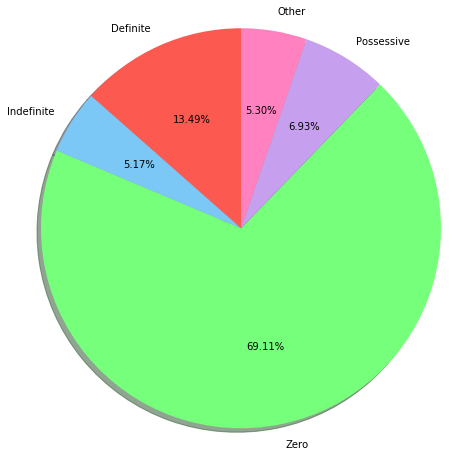

In [25]:
# Data to plot
labels = 'Definite', 'Indefinite', 'Zero', 'Possessive', 'Other'
sizes = [all_def, all_indef, all_zero, all_poss, all_other]
colors = ['xkcd:coral', 'xkcd:lightblue', 'xkcd:lightgreen', 'xkcd:lavender', 'xkcd:pink']
 
# Plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.savefig('../images/pelic_allarticles_pie.png', bbox_inches='tight')

Wow, that's strange. I was _not_ expecting 'the' to be so overshadowed by the zero article. Part of this certainly has to do with my `findArticles` function, which only accounts for the immediately preceding word for a noun (or a longer proper noun phrase), so I'm sure there are some cases of DT+ADJ+NN phrases that were coded as zero articles, but this is still surprising!

<a id='arapie'></a>
#### L1: Arabic

In [26]:
ara_def = getAll(arabic, 'sum_all_def')
ara_indef = getAll(arabic, 'sum_all_indef')
ara_zero = getAll(arabic, 'sum_all_zero')
ara_poss = getAll(arabic, 'sum_all_poss')
ara_other = getAll(arabic, 'sum_all_other')

21874
6536
100523
11057
8949


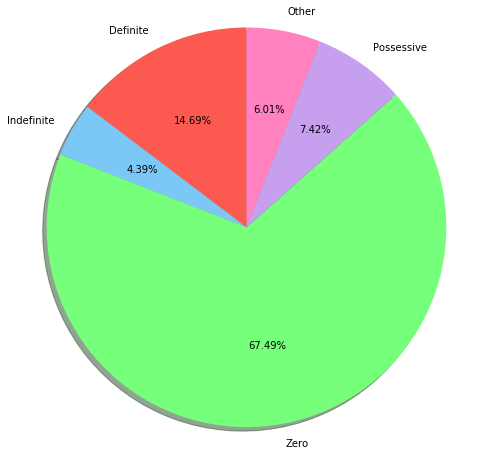

In [27]:
labels = 'Definite', 'Indefinite', 'Zero', 'Possessive', 'Other'
sizes = [ara_def, ara_indef, ara_zero, ara_poss, ara_other]
 
# Plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.savefig('../images/pelic_arabicarticles_pie.png', bbox_inches='tight')

<a id='korpie'></a>
#### L1: Korean

11671
6429
73174
6468
4275


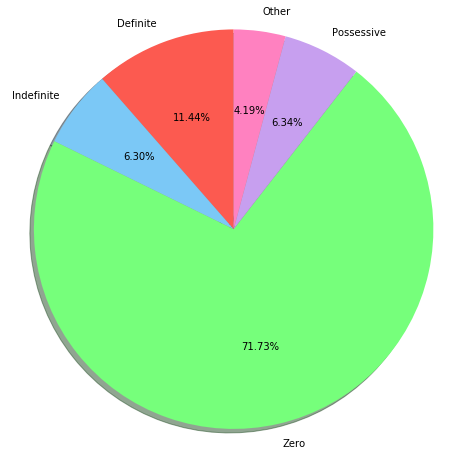

In [28]:
kor_def = getAll(korean, 'sum_all_def')
kor_indef = getAll(korean, 'sum_all_indef')
kor_zero = getAll(korean, 'sum_all_zero')
kor_poss = getAll(korean, 'sum_all_poss')
kor_other = getAll(korean, 'sum_all_other')

labels = 'Definite', 'Indefinite', 'Zero', 'Possessive', 'Other'
sizes = [kor_def, kor_indef, kor_zero, kor_poss, kor_other]
 
# Plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.savefig('../images/pelic_koreanarticles_pie.png', bbox_inches='tight')

<a id='spapie'></a>
#### L1: Spanish

2704
921
12028
1111
1025


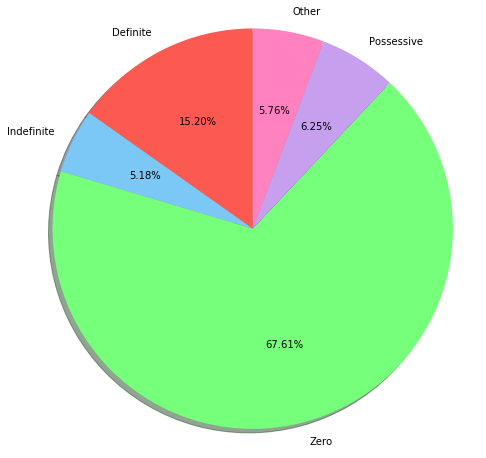

In [29]:
spa_def = getAll(spanish, 'sum_all_def')
spa_indef = getAll(spanish, 'sum_all_indef')
spa_zero = getAll(spanish, 'sum_all_zero')
spa_poss = getAll(spanish, 'sum_all_poss')
spa_other = getAll(spanish, 'sum_all_other')

labels = 'Definite', 'Indefinite', 'Zero', 'Possessive', 'Other'
sizes = [spa_def, spa_indef, spa_zero, spa_poss, spa_other]
 
# Plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
fig1.savefig('../images/pelic_spanisharticles_pie.png', bbox_inches='tight')

<a id='all'></a>
### All nouns
Do speakers in different L1s and/or levels use nouns differently?

In [30]:
pelic.groupby(['native_language'])['all_nouns'].describe()

,count,mean,std,min,25%,50%,75%,max
native_language,,,,,,,,
Arabic,3214.0,46.340697,58.853154,0.0,5.0,25.0,71.0,734.0
Korean,1928.0,52.913382,63.336821,0.0,6.0,31.0,76.0,594.0
Spanish,332.0,53.581325,57.755731,1.0,7.0,30.0,81.0,332.0


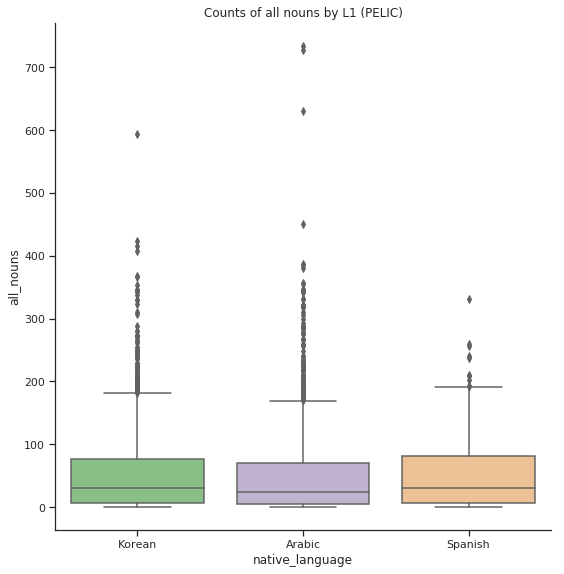

In [31]:
sns.set(style="ticks")
g = sns.catplot(x='native_language', y="all_nouns", kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Counts of all nouns by L1 (PELIC)')
g.savefig('../images/pelic_allnouns.png', bbox_inches='tight')

Without factoring in levels, it looks like the different L1s are all clustered together, in terms of raw count usage of nouns in general. Spanish L1 is a little closer together (without as many outliers) as either Arabic or Korean, but it also had the lowest counts! Spanish only had 332 documents, whereas Krean almost 2,000 and Arabic had over 3,000.

Why don't we try breaking this down by level?

In [32]:
pelic.groupby(['native_language', 'level_id'])['all_nouns'].describe()

count       mean        std  min   25%   50%   75%  \
native_language level_id                                                        
Arabic          3          732.0  22.064208  22.571970  0.0   3.0  17.0  34.0   
                4         1347.0  50.006682  46.648897  0.0   7.0  39.0  80.0   
                5         1135.0  57.646696  79.862996  0.0   5.0  21.0  85.0   
Korean          3          327.0  31.810398  24.405712  0.0  14.0  29.0  44.0   
                4          882.0  58.214286  53.246738  0.0  12.0  43.5  91.0   
                5          719.0  56.008345  82.280890  0.0   4.0  11.0  83.0   
Spanish         3           65.0  32.430769  27.418042  2.0  12.0  26.0  42.0   
                4          174.0  58.109195  60.332936  1.0   7.0  38.5  97.5   
                5           93.0  59.892473  65.103006  3.0   7.0  39.0  91.0   

                            max  
native_language level_id         
Arabic          3         126.0  
                4         346.0  
                5         734.0  
Korean          3         141.0  
                4         408.0  
                5         594.0  
Spanish         3         124.0  
                4         260.0  
                5         332.0

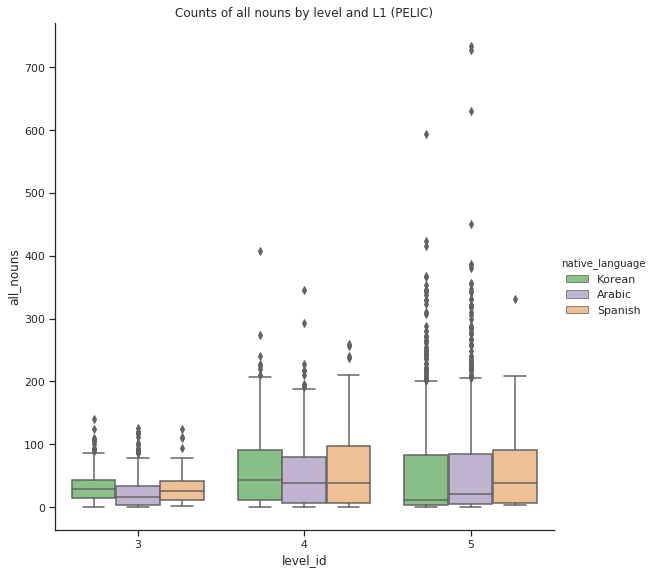

In [33]:
g = sns.catplot(x='level_id', y="all_nouns", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Counts of all nouns by level and L1 (PELIC)')
g.savefig('../images/pelic_allnouns_bylvl-L1.png', bbox_inches='tight')

So across levels, it looks like speakers from different L1s typically seem to act similarly in (total) noun usage. The Level 3 students have a more compact usage and use what seems like fewer numbers of nouns in their documents, but this is probably also related to text length -- as students get higher in level, they typically start to use more words in general.

<a id='nstokrat'></a>
### Ratio of nouns:all_toks
Are nouns evenly distributed aross levels and L1s?

In [34]:
pelic.groupby(['native_language'])['noun:tok_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
native_language,,,,,,,,
Arabic,3213.0,0.270804,0.095109,0.000000,0.218750,0.260870,0.306306,1.000000
Korean,1928.0,0.266255,0.101519,0.000000,0.214286,0.256579,0.303219,1.000000
Spanish,332.0,0.287931,0.081261,0.086207,0.239560,0.272814,0.329929,0.631579


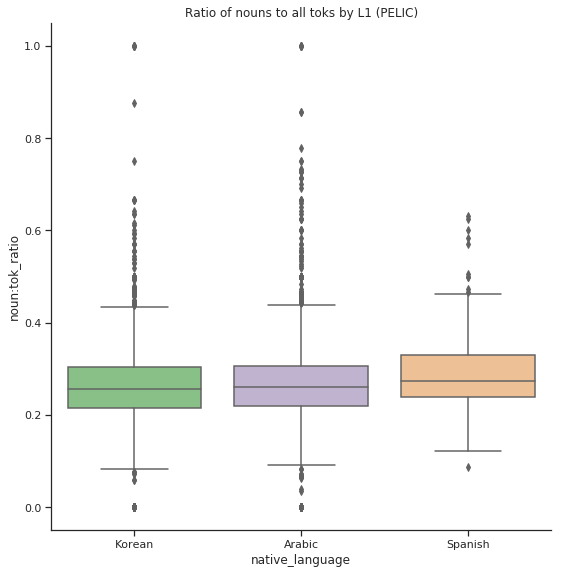

In [35]:
g = sns.catplot(x='native_language', y="noun:tok_ratio", kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Ratio of nouns to all toks by L1 (PELIC)')
g.savefig('../images/pelic_noun-tokratio.png', bbox_inches='tight')

Again, when we're just looking at the L1s with no reference to level, they seem to be relatively similar. Interestingly, Spanish L1 speakers never have a ratio of 0, so in every document, they have at least one noun.

Regarding the 1.0 ratio, this measure is similar to type:token ratio in that it is affected by text length. There are some texts in the corpus that are anywhere from 1 to 10 words long. Thus, those texts may have just two or three different types of words. For example, I know for a fact that one text is just 'Some time' -- that would have a ratio of 1.0, since there are only two words -- one noun, and one other word.

But let's break it down by level before moving on.

In [36]:
pelic.groupby(['native_language', 'level_id'])['noun:tok_ratio'].describe()

count      mean       std       min       25%  \
native_language level_id                                                   
Arabic          3          731.0  0.262042  0.099862  0.000000  0.209105   
                4         1347.0  0.271841  0.095150  0.000000  0.219914   
                5         1135.0  0.275216  0.091572  0.000000  0.222222   
Korean          3          327.0  0.266887  0.078933  0.000000  0.215771   
                4          882.0  0.264518  0.090423  0.000000  0.215136   
                5          719.0  0.268099  0.121620  0.000000  0.213359   
Spanish         3           65.0  0.276073  0.068183  0.086207  0.227273   
                4          174.0  0.294611  0.091811  0.120879  0.235294   
                5           93.0  0.283720  0.066869  0.146341  0.245399   

                               50%       75%       max  
native_language level_id                                
Arabic          3         0.250000  0.307692  1.000000  
                4         0.258206  0.300000  1.000000  
                5         0.268446  0.310051  1.000000  
Korean          3         0.265823  0.309981  0.538462  
                4         0.252936  0.292357  1.000000  
                5         0.259200  0.309017  1.000000  
Spanish         3         0.274725  0.309859  0.461538  
                4         0.272814  0.333333  0.631579  
                5         0.272727  0.317536  0.500000

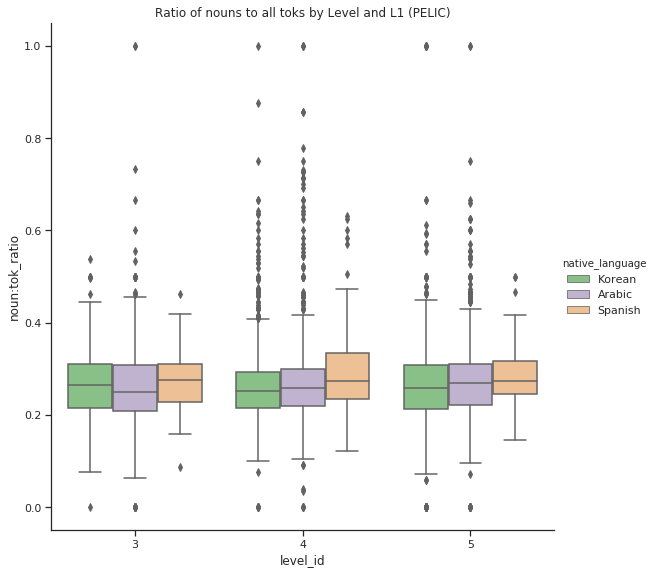

In [37]:
g = sns.catplot(x='level_id', y="noun:tok_ratio", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Ratio of nouns to all toks by Level and L1 (PELIC)')
g.savefig('../images/pelic_noun-tokratio_bylvl-L1.png', bbox_inches='tight')

When broken down by level and L1, it seems like all speakers have a pretty regular ratio of nouns to all tokens across the board.

<a id='def'></a>
### Definite articles
Who is using definite articles the most?

In [38]:
pelic.groupby(['native_language', 'level_id'])['sum_all_def'].describe()

count       mean        std  min  25%  50%    75%  \
native_language level_id                                                       
Arabic          3          732.0   3.209016   4.705415  0.0  0.0  1.0   4.00   
                4         1347.0   7.472903   8.568133  0.0  1.0  4.0  11.00   
                5         1135.0   8.333921  11.873393  0.0  0.0  3.0  12.00   
Korean          3          327.0   3.238532   3.994396  0.0  0.0  2.0   5.00   
                4          882.0   6.261905   8.234813  0.0  1.0  3.0   9.00   
                5          719.0   7.077886  12.242537  0.0  0.0  1.0   8.00   
Spanish         3           65.0   4.707692   5.519067  0.0  1.0  3.0   6.00   
                4          174.0   8.258621   9.599904  0.0  1.0  4.0  12.75   
                5           93.0  10.333333  11.532877  0.0  1.0  5.0  17.00   

                           max  
native_language level_id        
Arabic          3         30.0  
                4         66.0  
                5         77.0  
Korean          3         24.0  
                4         62.0  
                5         98.0  
Spanish         3         28.0  
                4         41.0  
                5         58.0

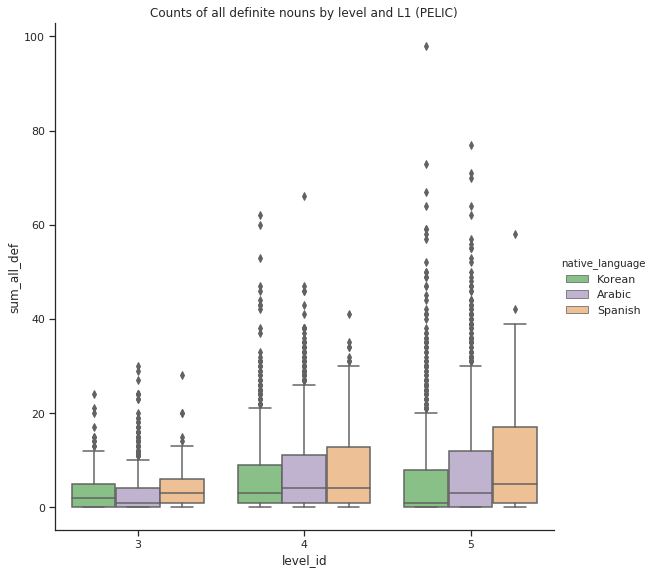

In [39]:
g = sns.catplot(x='level_id', y="sum_all_def", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Counts of all definite nouns by level and L1 (PELIC)')
g.savefig('../images/pelic_alldefns_bylvl-L1.png', bbox_inches='tight')

<a id='def:all'></a>
### Ratio of definite articles to all nouns present

In [40]:
pelic.groupby(['native_language', 'level_id'])['def:noun_ratio'].describe()

count      mean       std  min       25%       50%  \
native_language level_id                                                        
Arabic          3          716.0  0.139312  0.168867  0.0  0.000000  0.086335   
                4         1342.0  0.163164  0.168398  0.0  0.052719  0.125658   
                5         1121.0  0.147203  0.154856  0.0  0.000000  0.122807   
Korean          3          326.0  0.095003  0.116286  0.0  0.000000  0.058824   
                4          875.0  0.098119  0.098921  0.0  0.021391  0.075758   
                5          692.0  0.110436  0.130427  0.0  0.000000  0.084533   
Spanish         3           65.0  0.161602  0.142363  0.0  0.058824  0.133333   
                4          174.0  0.162800  0.172754  0.0  0.062832  0.125992   
                5           93.0  0.185330  0.114820  0.0  0.113514  0.172727   

                               75%  max  
native_language level_id                 
Arabic          3         0.212370  1.0  
                4         0.216817  1.0  
                5         0.203704  1.0  
Korean          3         0.146825  1.0  
                4         0.145591  1.0  
                5         0.166667  1.0  
Spanish         3         0.222222  0.5  
                4         0.214286  1.0  
                5         0.246154  0.6

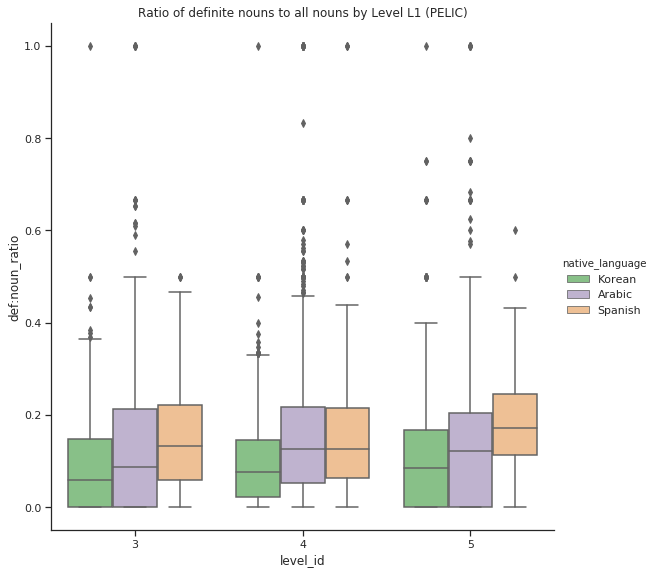

In [41]:
g = sns.catplot(x='level_id', y="def:noun_ratio", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Ratio of definite nouns to all nouns by Level L1 (PELIC)')
g.savefig('../images/pelic_defn-allnratio_bylvl-L1.png', bbox_inches='tight')

<a id='indef'></a>
### Indefinite articles
Who is using indefinite articles the most?

In [42]:
pelic.groupby(['native_language', 'level_id'])['sum_all_indef'].describe()

count      mean       std  min  25%  50%  75%   max
native_language level_id                                                      
Arabic          3          732.0  0.945355  1.678631  0.0  0.0  0.0  1.0  11.0
                4         1347.0  2.298441  3.089072  0.0  0.0  1.0  4.0  22.0
                5         1135.0  2.421145  4.070877  0.0  0.0  1.0  3.0  32.0
Korean          3          327.0  2.311927  3.118411  0.0  0.0  1.0  3.0  24.0
                4          882.0  3.385488  4.239019  0.0  0.0  2.0  5.0  28.0
                5          719.0  3.737135  6.598020  0.0  0.0  1.0  4.0  62.0
Spanish         3           65.0  1.861538  2.732198  0.0  0.0  1.0  2.0  14.0
                4          174.0  2.936782  3.922887  0.0  0.0  1.5  5.0  21.0
                5           93.0  3.107527  4.166279  0.0  1.0  1.0  4.0  27.0

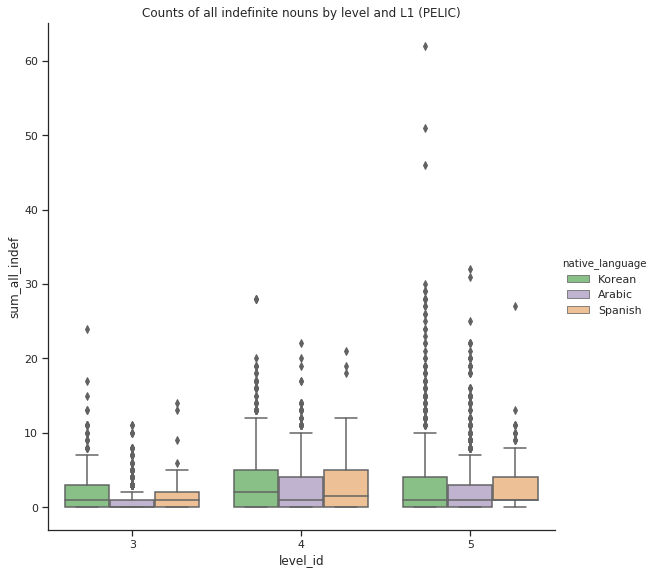

In [43]:
g = sns.catplot(x='level_id', y="sum_all_indef", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Counts of all indefinite nouns by level and L1 (PELIC)')
g.savefig('../images/pelic_allindefns_bylvl-L1.png', bbox_inches='tight')

<a id='indef:all'></a>
### Ratio of indefinite articles to all nouns present

In [44]:
pelic.groupby(['native_language', 'level_id'])['indef:noun_ratio'].describe()

count      mean       std  min       25%       50%  \
native_language level_id                                                        
Arabic          3          716.0  0.040446  0.079578  0.0  0.000000  0.000000   
                4         1342.0  0.043407  0.068747  0.0  0.000000  0.022727   
                5         1121.0  0.044512  0.085551  0.0  0.000000  0.013514   
Korean          3          326.0  0.070245  0.101033  0.0  0.000000  0.039231   
                4          875.0  0.059543  0.081880  0.0  0.000000  0.038462   
                5          692.0  0.082722  0.134492  0.0  0.000000  0.038462   
Spanish         3           65.0  0.064868  0.097645  0.0  0.000000  0.037037   
                4          174.0  0.041147  0.052607  0.0  0.000000  0.027544   
                5           93.0  0.059141  0.057509  0.0  0.015385  0.050000   

                               75%       max  
native_language level_id                      
Arabic          3         0.049180  0.500000  
                4         0.061824  1.000000  
                5         0.053691  1.000000  
Korean          3         0.103227  1.000000  
                4         0.080000  1.000000  
                5         0.100773  1.000000  
Spanish         3         0.083333  0.500000  
                4         0.065957  0.350000  
                5         0.083333  0.333333

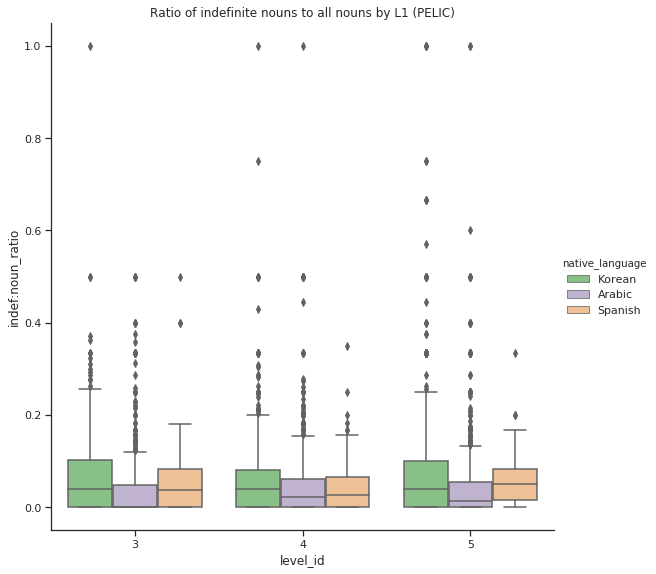

In [45]:
g = sns.catplot(x='level_id', y="indef:noun_ratio", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Ratio of indefinite nouns to all nouns by L1 (PELIC)')
g.savefig('../images/pelic_indefn-allnratio_bylvl-L1.png', bbox_inches='tight')

<a id='zero'></a>
### Zero articles
Who is using zero articles the most?

In [46]:
pelic.groupby(['native_language', 'level_id'])['sum_all_zero'].describe()

count       mean        std  min   25%   50%  \
native_language level_id                                                  
Arabic          3          732.0  14.668033  16.072780  0.0  2.00   9.0   
                4         1347.0  33.167780  32.756952  0.0  5.00  24.0   
                5         1135.0  39.743612  59.431050  0.0  3.00  12.0   
Korean          3          327.0  22.825688  19.483127  0.0  9.00  19.0   
                4          882.0  42.123583  40.533216  0.0  9.00  30.0   
                5          719.0  39.717663  60.186499  0.0  3.00   8.0   
Spanish         3           65.0  21.784615  20.889211  0.0  6.00  16.0   
                4          174.0  39.902299  42.661955  0.0  5.25  23.0   
                5           93.0  39.451613  44.523447  1.0  5.00  25.0   

                            75%    max  
native_language level_id                
Arabic          3         21.00   96.0  
                4         53.00  254.0  
                5         57.00  603.0  
Korean          3         31.00  123.0  
                4         65.00  282.0  
                5         55.50  461.0  
Spanish         3         25.00   95.0  
                4         66.75  199.0  
                5         59.00  249.0

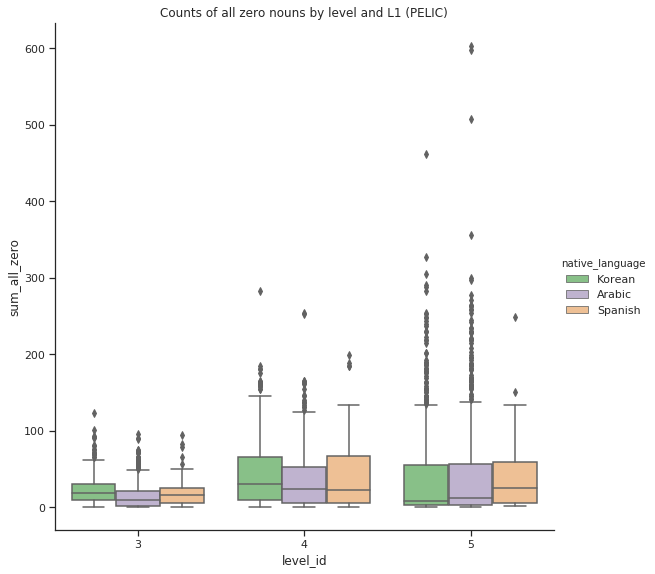

In [47]:
g = sns.catplot(x='level_id', y="sum_all_zero", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Counts of all zero nouns by level and L1 (PELIC)')
g.savefig('../images/pelic_allzerons_bylvl-L1.png', bbox_inches='tight')

<a id='zero:all'></a>
### Ratio of zero articles to all other nouns

In [48]:
pelic.groupby(['native_language', 'level_id'])['zero:noun_ratio'].describe()

count      mean       std  min       25%       50%  \
native_language level_id                                                        
Arabic          3          716.0  0.656182  0.235403  0.0  0.500000  0.666667   
                4         1342.0  0.664915  0.197570  0.0  0.571429  0.666667   
                5         1121.0  0.668814  0.206921  0.0  0.560241  0.679245   
Korean          3          326.0  0.708269  0.189317  0.0  0.592882  0.726381   
                4          875.0  0.715496  0.172779  0.0  0.627662  0.725000   
                5          692.0  0.700644  0.215369  0.0  0.600000  0.713820   
Spanish         3           65.0  0.620929  0.198158  0.0  0.500000  0.666667   
                4          174.0  0.696123  0.184881  0.0  0.600350  0.704125   
                5           93.0  0.645592  0.140788  0.2  0.586957  0.661017   

                               75%   max  
native_language level_id                  
Arabic          3         0.812500  1.00  
                4         0.770552  1.00  
                5         0.800000  1.00  
Korean          3         0.840359  1.00  
                4         0.820256  1.00  
                5         0.833333  1.00  
Spanish         3         0.777778  0.88  
                4         0.792823  1.00  
                5         0.727273  1.00

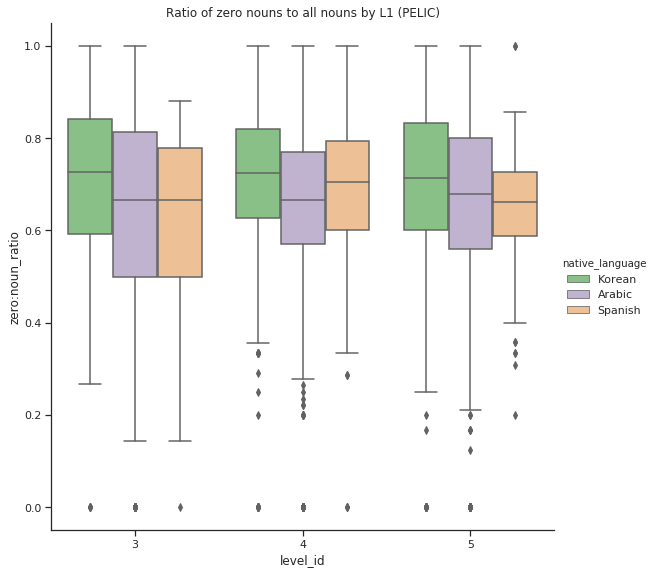

In [49]:
g = sns.catplot(x='level_id', y="zero:noun_ratio", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Ratio of zero nouns to all nouns by L1 (PELIC)')
g.savefig('../images/pelic_zeron-allnratio_bylvl-L1.png', bbox_inches='tight')

<a id='erroranalysis'></a>
### Errors: Articles in front of plural common nouns
In this section, we'll take a look at some analysis that is fairly easy to automate: what article comes in front a plural count noun? While the usage of English articles is fairly dependent on context, there are some rules that have little leeway.

One such example is what articles can be used in front of a plural noun. While either definite or zero articles can be used in front of plural nouns (depending on the context and certain pragmatic concerns), an indefinite article _can not_ come before a plural nominal form. See the example below:
- ∅ Swedes are rich.
- The Swedes are rich.
- \*A Swedes are rich.

While either of the first two sentences should sound grammatical to native speakers of English, the last certainly shouldn't, regardless of English dialect spoken.

#### Definite article + Plural common noun

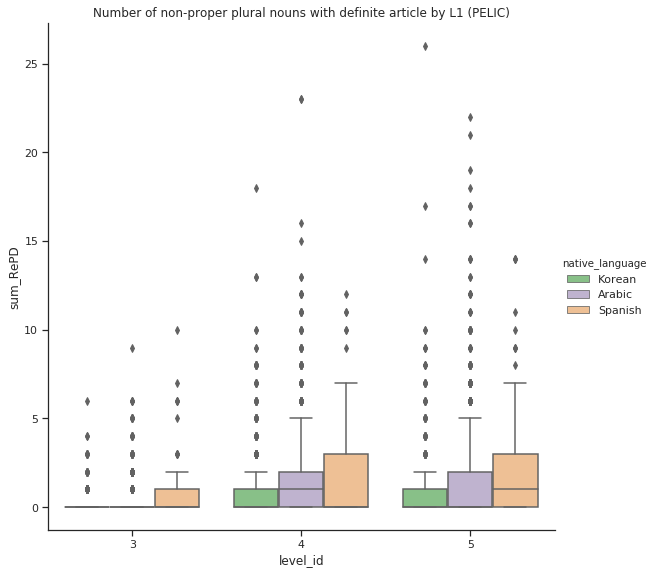

In [50]:
g = sns.catplot(x= 'level_id', y="sum_RePD", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of non-proper plural nouns with definite article by L1 (PELIC)')
g.savefig('../images/pelic_plns_def.png', bbox_inches='tight')

#### Indefinite article + Plural common noun

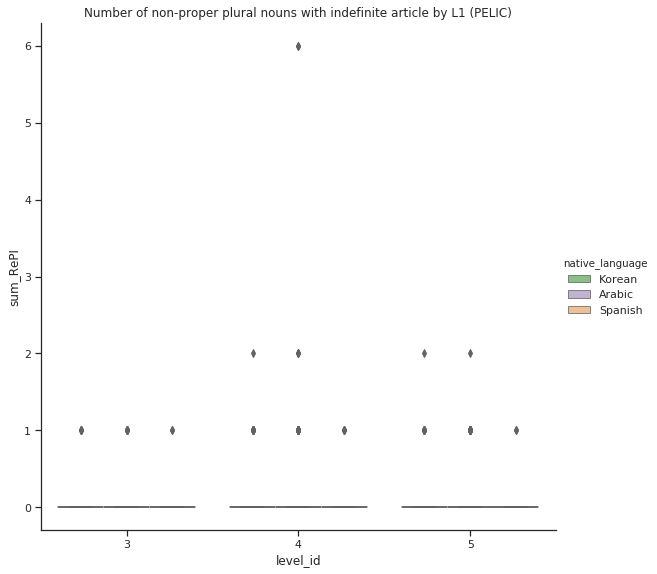

In [51]:
g = sns.catplot(x= 'level_id', y="sum_RePI", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of non-proper plural nouns with indefinite article by L1 (PELIC)')
g.savefig('../images/pelic_plns_indef.png', bbox_inches='tight')

#### Zero article + Plural common noun

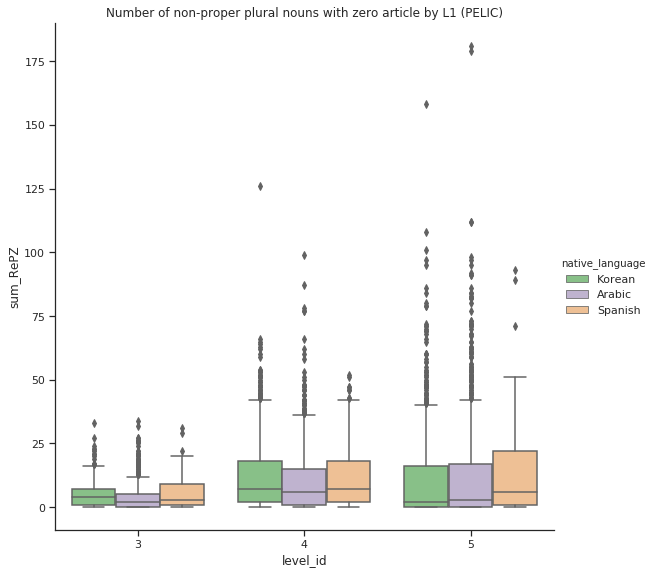

In [54]:
g = sns.catplot(x= 'level_id', y="sum_RePZ", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of non-proper plural nouns with zero article by L1 (PELIC)')
g.savefig('../images/pelic_plns_zero.png', bbox_inches='tight')

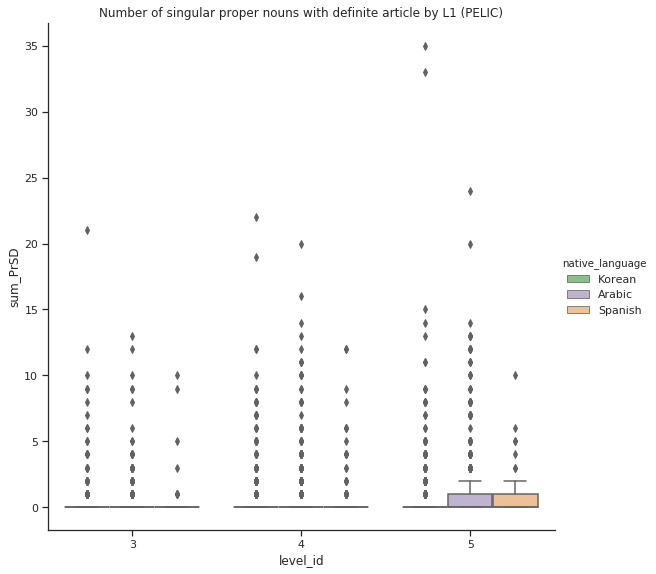

In [55]:
g = sns.catplot(x= 'level_id', y="sum_PrSD", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of singular proper nouns with definite article by L1 (PELIC)')
g.savefig('../images/pelic_nnpns_def.png', bbox_inches='tight')

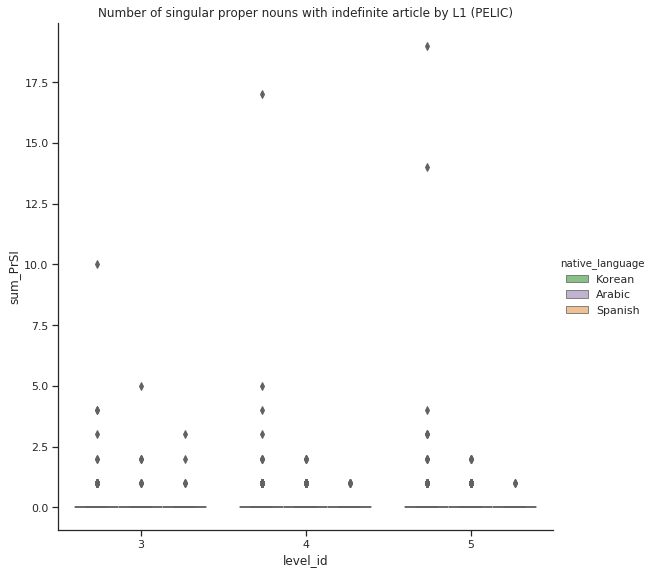

In [56]:
g = sns.catplot(x= 'level_id', y="sum_PrSI", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of singular proper nouns with indefinite article by L1 (PELIC)')
g.savefig('../images/pelic_nnpns_indef.png', bbox_inches='tight')

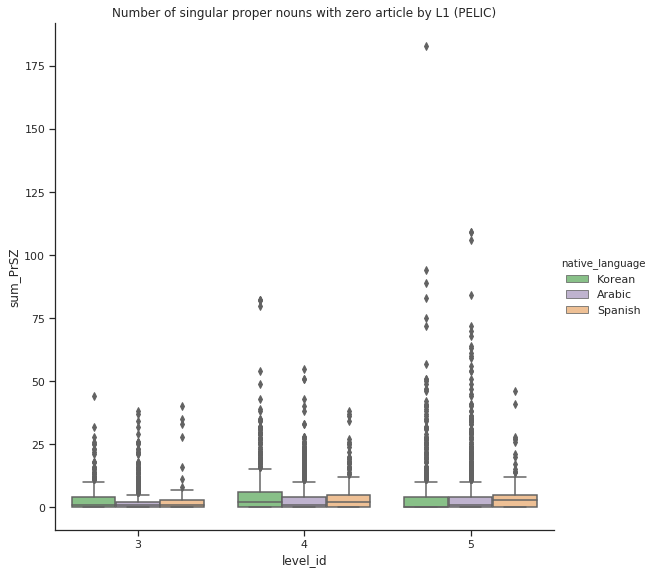

In [57]:
g = sns.catplot(x= 'level_id', y="sum_PrSZ", hue= 'native_language', kind='box',
                data=pelic, palette="Accent", height=8)
plt.title('Number of singular proper nouns with zero article by L1 (PELIC)')
g.savefig('../images/pelic_nnpns_zero.png', bbox_inches='tight')

<a id='mostcommon'></a>
### Most common nouns to follow articles in each L1 and level
In this section, we'll look at what the most common nouns are for each target article condition (definite, indefinite, zero) for each L1 (Arabic, Korean, Spanish) at each level (3, 4, 5).

In [58]:
def getCounter(df, level, column, article, name):
    c = Counter()
    for item in df[df.level_id == level][column]:
        c.update(item)
    df = pd.DataFrame(data=c, index=[0]).T
    df = df.sort_values(by=[0], ascending=False)
    df = df.reset_index([0])
    df.columns = ['word', 'count']
    df['article'] = article
    df['name'] = name
    return df

In [59]:
# get all the Arabic
A3D = getCounter(arabic, 3, 'all_def', 'definite', 'Arabic L1, Level 3')
A3I = getCounter(arabic, 3, 'all_indef', 'indefinite', 'Arabic L1, Level 3')
A3Z = getCounter(arabic, 3, 'all_zero', 'zero', 'Arabic L1, Level 3')

A4D = getCounter(arabic, 4, 'all_def', 'definite', 'Arabic L1, Level 4')
A4I = getCounter(arabic, 4, 'all_indef', 'indefinite', 'Arabic L1, Level 4')
A4Z = getCounter(arabic, 4, 'all_zero', 'zero', 'Arabic L1, Level 4')

A5D = getCounter(arabic, 5, 'all_def', 'definite', 'Arabic L1, Level 5')
A5I = getCounter(arabic, 5, 'all_indef', 'indefinite', 'Arabic L1, Level 5')
A5Z = getCounter(arabic, 5, 'all_zero', 'zero', 'Arabic L1, Level 5')

In [60]:
# get all the Korean
K3D = getCounter(korean, 3, 'all_def', 'definite', 'Korean L1, Level 3')
K3I = getCounter(korean, 3, 'all_indef', 'indefinite', 'Korean L1, Level 3')
K3Z = getCounter(korean, 3, 'all_zero', 'zero', 'Korean L1, Level 3')

K4D = getCounter(korean, 4, 'all_def', 'definite', 'Korean L1, Level 4')
K4I = getCounter(korean, 4, 'all_indef', 'indefinite', 'Korean L1, Level 4')
K4Z = getCounter(korean, 4, 'all_zero', 'zero', 'Korean L1, Level 4')

K5D = getCounter(korean, 5, 'all_def', 'definite', 'Korean L1, Level 5')
K5I = getCounter(korean, 5, 'all_indef', 'indefinite', 'Korean L1, Level 5')
K5Z = getCounter(korean, 5, 'all_zero', 'zero', 'Korean L1, Level 5')

In [61]:
# get all the Spanish
S3D = getCounter(spanish, 3, 'all_def', 'definite', 'Spanish L1, Level 3')
S3I = getCounter(spanish, 3, 'all_indef', 'indefinite', 'Spanish L1, Level 3')
S3Z = getCounter(spanish, 3, 'all_zero', 'zero', 'Spanish L1, Level 3')

S4D = getCounter(spanish, 4, 'all_def', 'definite', 'Spanish L1, Level 4')
S4I = getCounter(spanish, 4, 'all_indef', 'indefinite', 'Spanish L1, Level 4')
S4Z = getCounter(spanish, 4, 'all_zero', 'zero', 'Spanish L1, Level 4')

S5D = getCounter(spanish, 5, 'all_def', 'definite', 'Spanish L1, Level 5')
S5I = getCounter(spanish, 5, 'all_indef', 'indefinite', 'Spanish L1, Level 5')
S5Z = getCounter(spanish, 5, 'all_zero', 'zero', 'Spanish L1, Level 5')

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


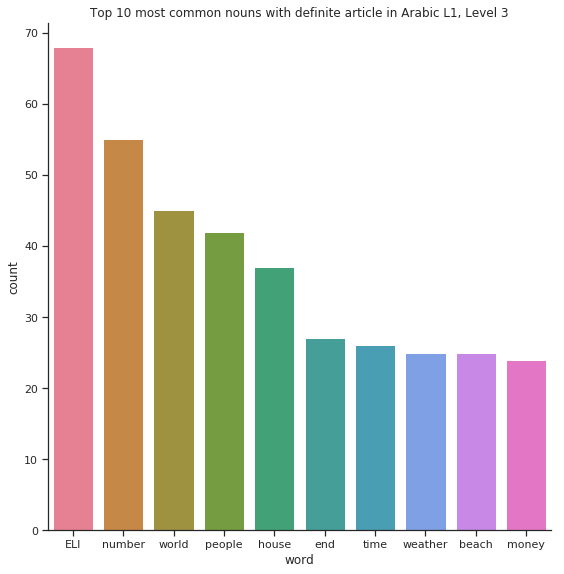

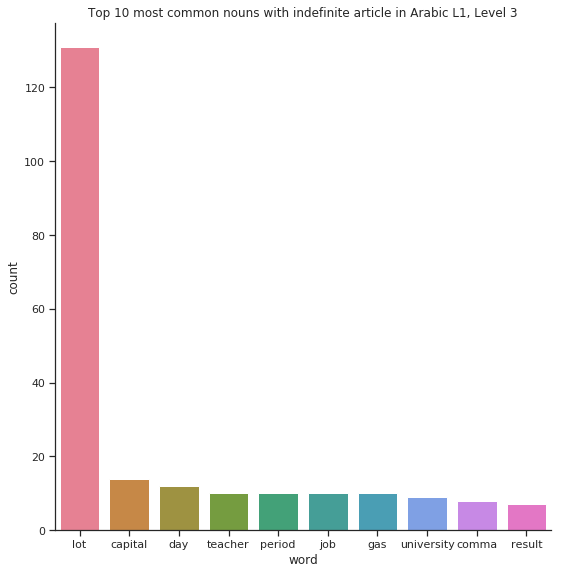

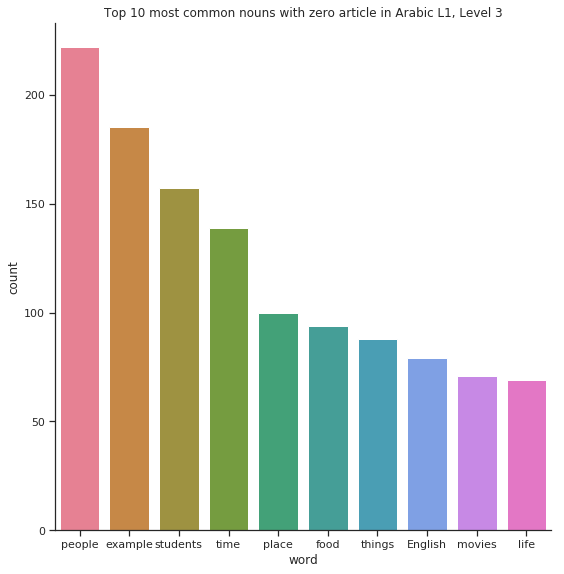

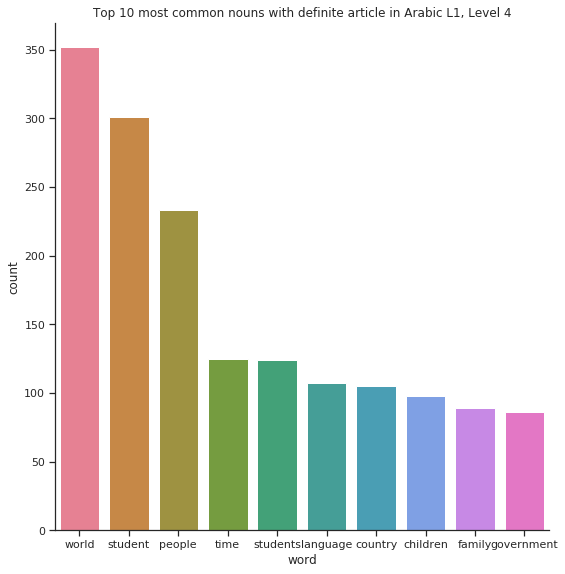

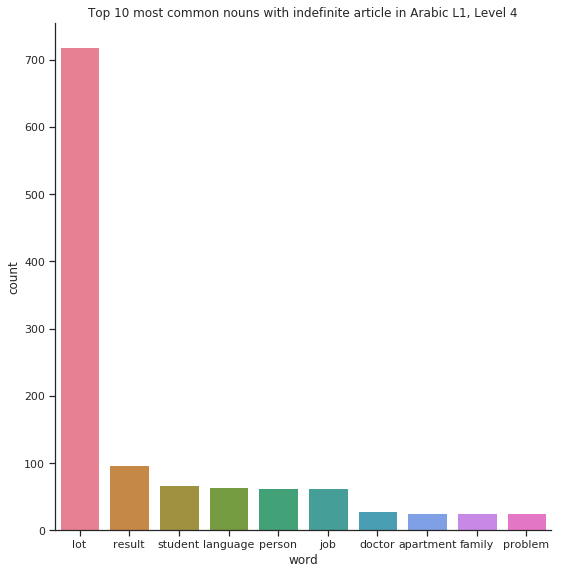

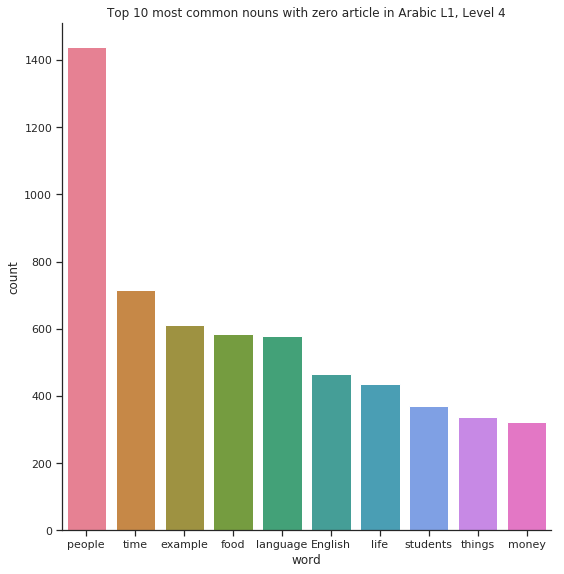

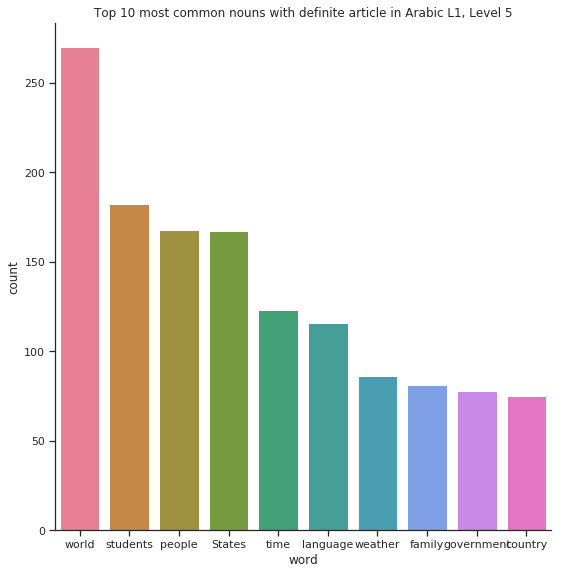

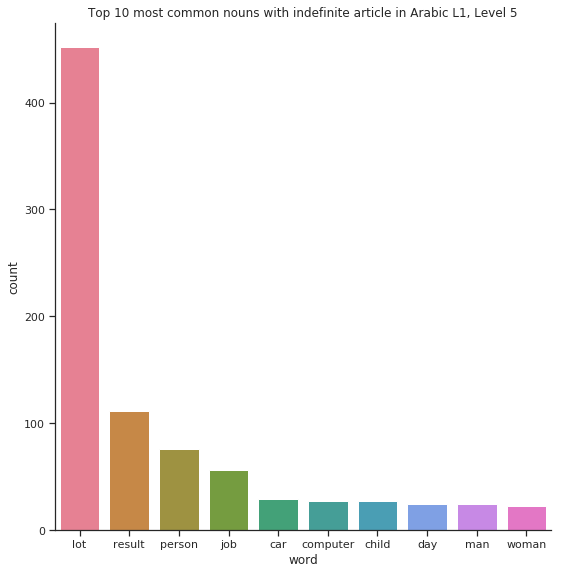

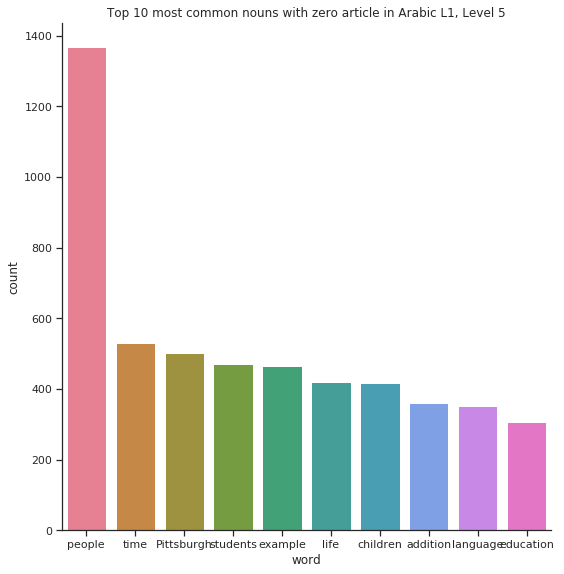

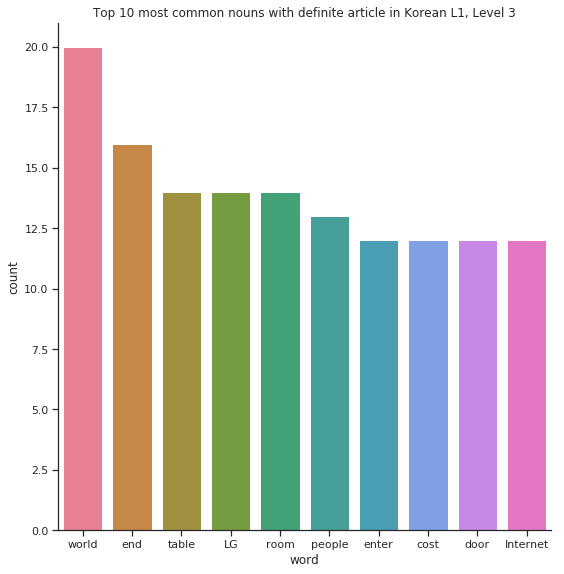

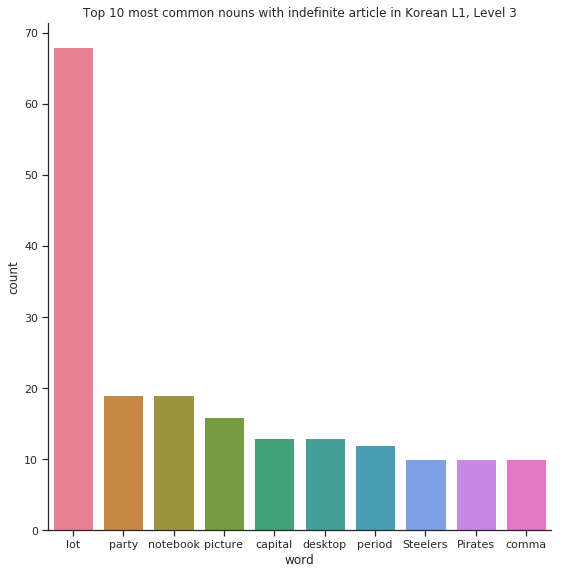

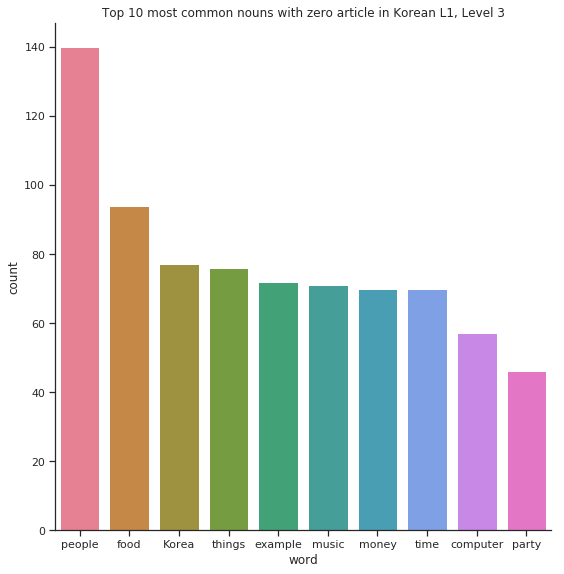

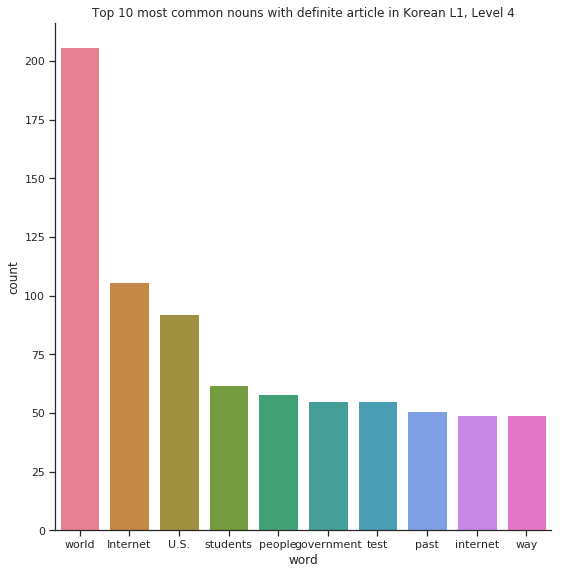

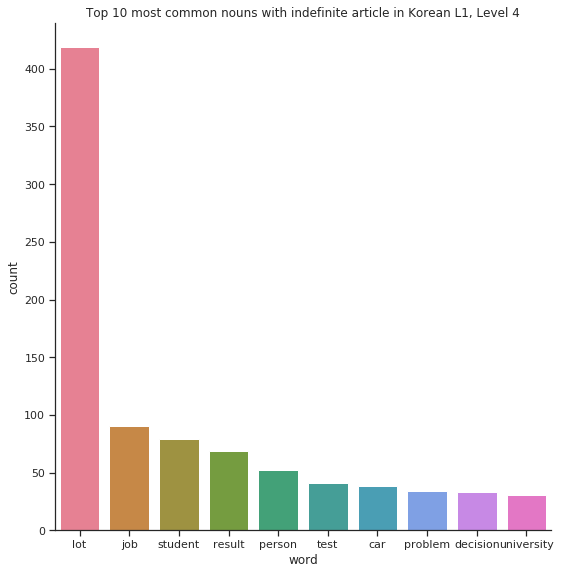

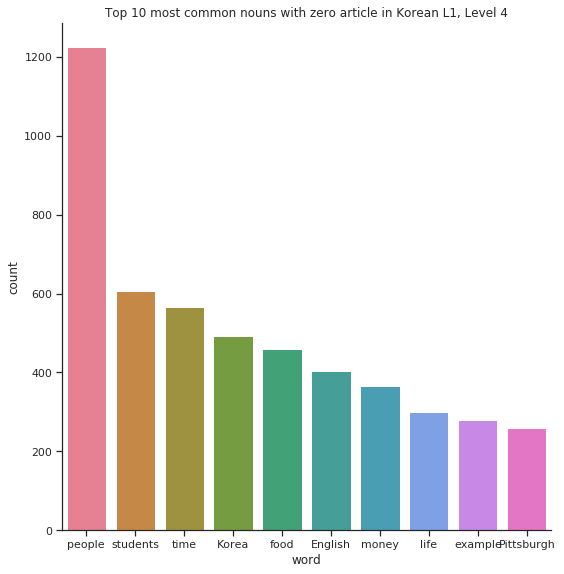

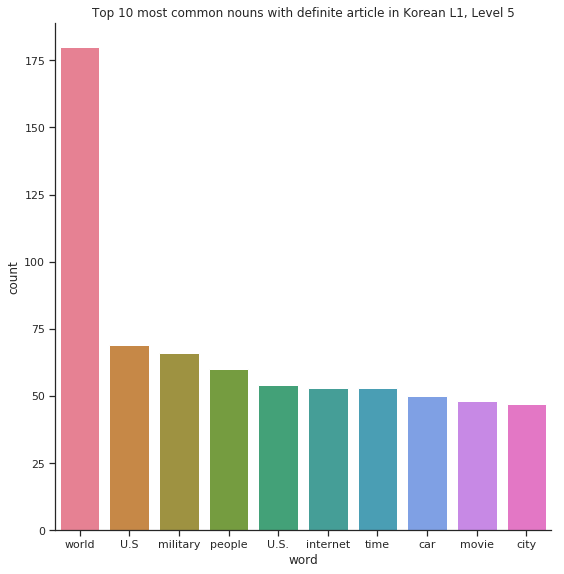

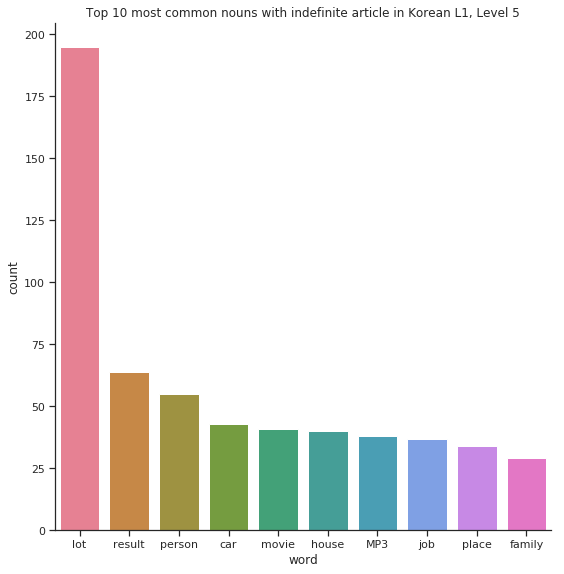

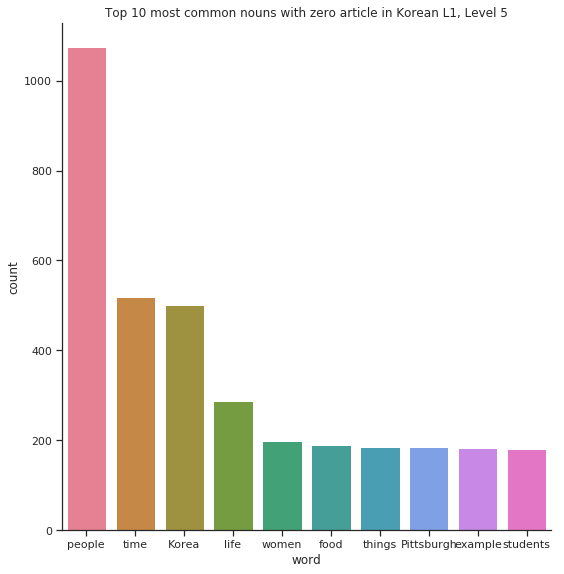

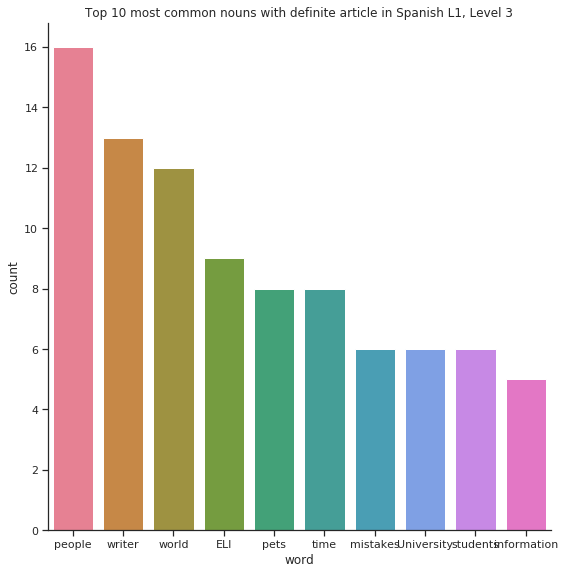

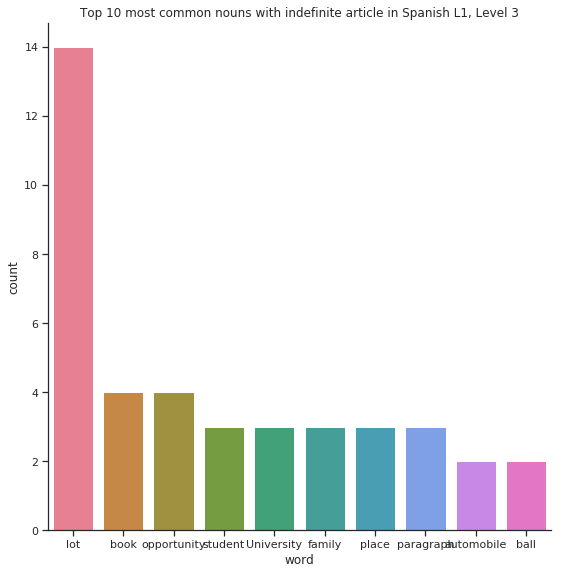

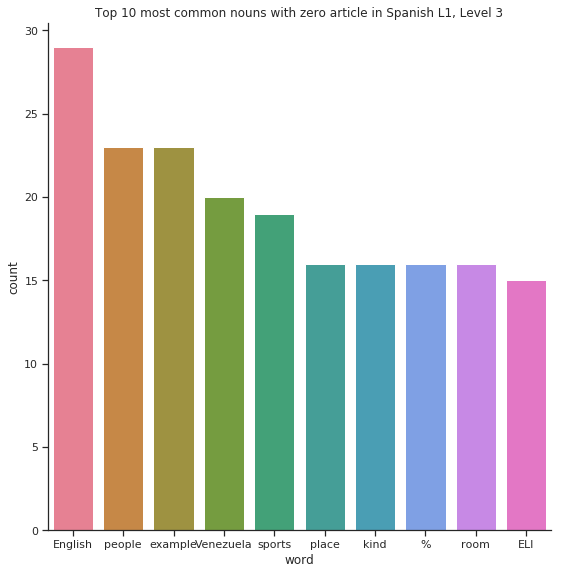

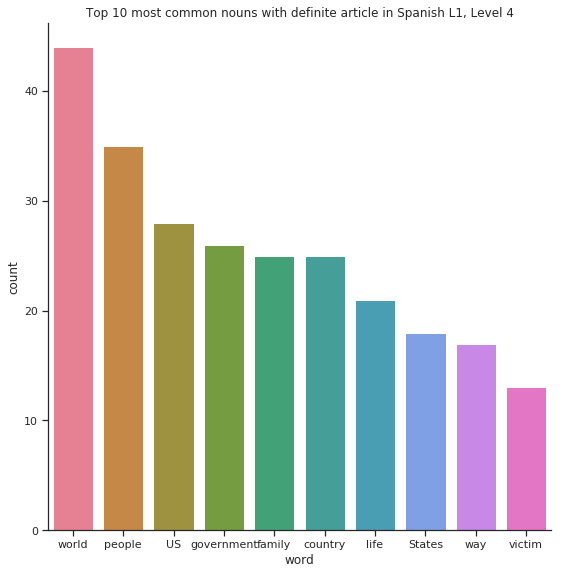

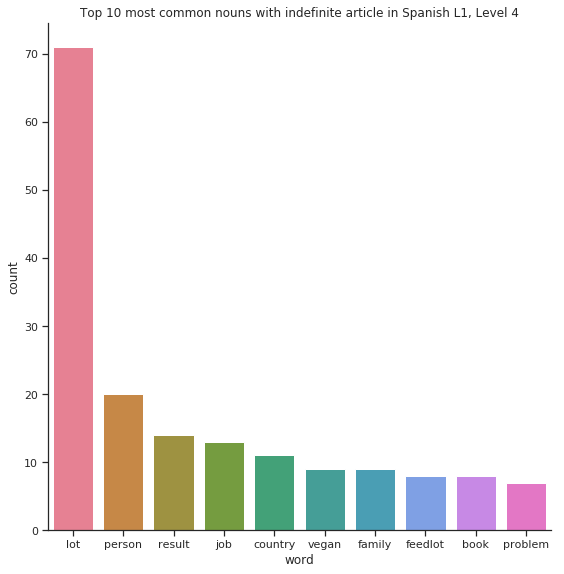

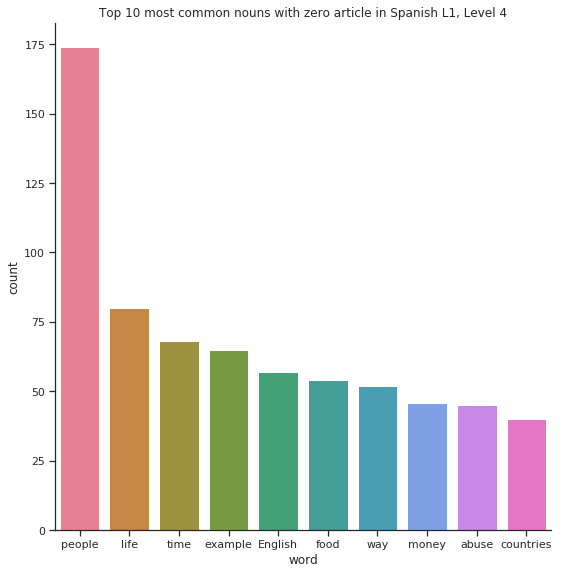

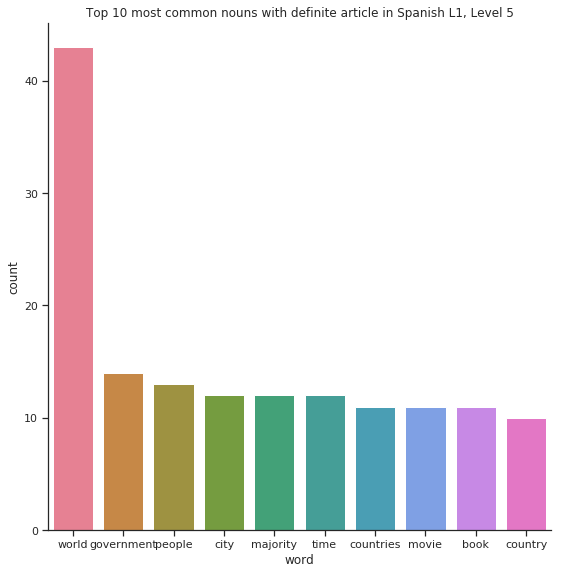

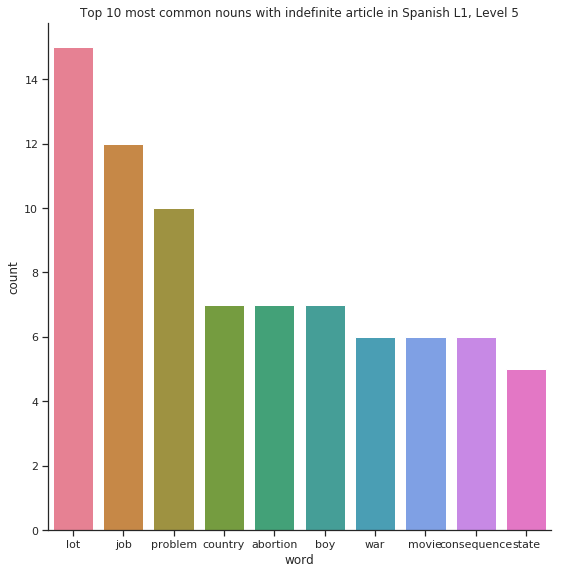

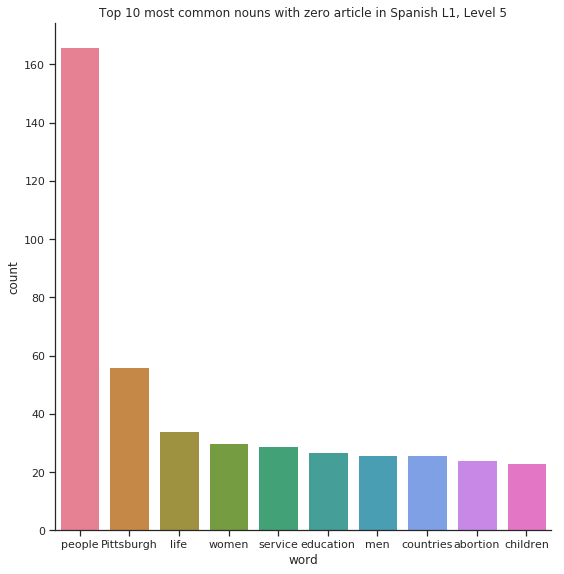

In [62]:
dfs = [A3D, A3I, A3Z, 
       A4D, A4I, A4Z,
       A5D, A5I, A5Z,
       K3D, K3I, K3Z, 
       K4D, K4I, K4Z,
       K5D, K5I, K5Z,
       S3D, S3I, S3Z, 
       S4D, S4I, S4Z,
       S5D, S5I, S5Z,]
root = '../images/'
name = 'pelic_mostcommon_'
num = 1
ext = '.png'
for df in dfs:
    g = sns.catplot(x= 'word', y="count", kind='bar',
                data=df.head(10), palette="husl", height=8)
    plt.title('Top 10 most common nouns with '+df['article'][0]+' article in '+df['name'][0])
    g.savefig(root+name+str(num)+ext, bbox_inches='tight')
    num += 1

comments

In [63]:
pelic.columns

Index(['question_id', 'anon_id', 'user_file_id', 'text', 'class_code',
       'level_id', 'native_language', 'version', 'toks_re', 'toks_re_len',
       'toks_nltk', 'Guiraud', 'pos', 'article_info', 'all_def', 'all_indef',
       'all_zero', 'all_poss', 'all_other', 'sum_all_def', 'sum_all_indef',
       'sum_all_zero', 'sum_all_poss', 'sum_all_other', 'all_nouns',
       'noun:tok_ratio', 'def:noun_ratio', 'indef:noun_ratio',
       'zero:noun_ratio', 'poss:noun_ratio', 'other:noun_ratio', 'RegPlDef',
       'RegPlIndef', 'RegPlZero', 'sum_RePD', 'sum_RePI', 'sum_RePZ',
       'ProperSingDef', 'ProperSingIndef', 'ProperSingZero', 'sum_PrSD',
       'sum_PrSI', 'sum_PrSZ'],
      dtype='object')

Plural indefinite nouns

In [64]:
all_plindef_values = getAll(pelic, 'sum_RePI')
ara_plindef_values = getAll(arabic, 'sum_RePI')
kor_plindef_values = getAll(korean, 'sum_RePI')
spa_plindef_values = getAll(spanish, 'sum_RePI')

123
81
33
9


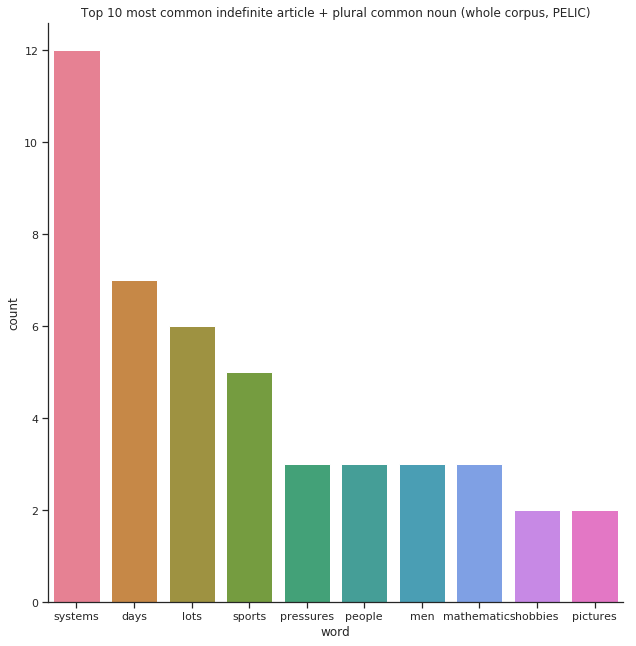

In [79]:
c = Counter()
for item in pelic['RegPlIndef']:
    c.update(item)
df = pd.DataFrame(data=c, index=[0]).T
df = df.sort_values(by=[0], ascending=False)
df = df.reset_index([0])
df.columns = ['word', 'count']
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=df.head(10), palette="husl", height=9)
plt.title('Top 10 most common indefinite article + plural common noun (whole corpus, PELIC)')
g.savefig('../images/pelic_plnsindef_common_all.png', bbox_inches='tight')

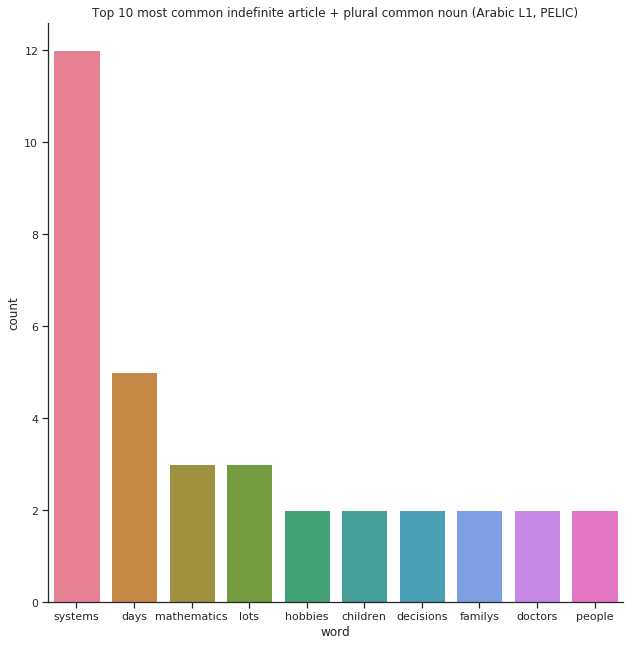

In [80]:
c = Counter()
for item in pelic[pelic.native_language=='Arabic']['RegPlIndef']:
    c.update(item)
df = pd.DataFrame(data=c, index=[0]).T
df = df.sort_values(by=[0], ascending=False)
df = df.reset_index([0])
df.columns = ['word', 'count']
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=df.head(10), palette="husl", height=9)
plt.title('Top 10 most common indefinite article + plural common noun (Arabic L1, PELIC)')
g.savefig('../images/pelic_plnsindef_common_ara.png', bbox_inches='tight')

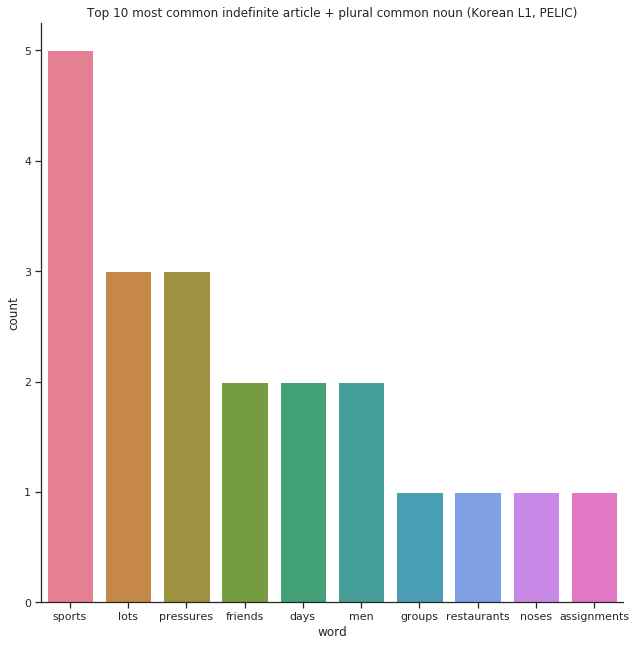

In [81]:
c = Counter()
for item in pelic[pelic.native_language=='Korean']['RegPlIndef']:
    c.update(item)
df = pd.DataFrame(data=c, index=[0]).T
df = df.sort_values(by=[0], ascending=False)
df = df.reset_index([0])
df.columns = ['word', 'count']
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=df.head(10), palette="husl", height=9)
plt.title('Top 10 most common indefinite article + plural common noun (Korean L1, PELIC)')
g.savefig('../images/pelic_plnsindef_common_kor.png', bbox_inches='tight')

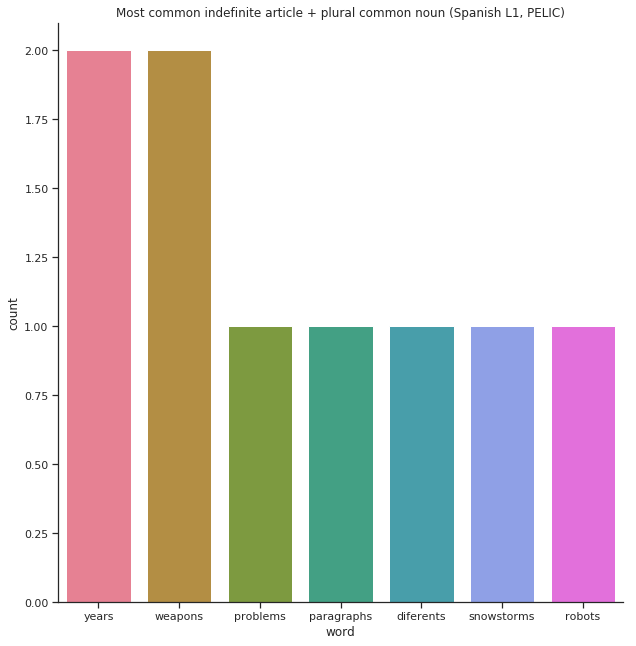

In [83]:
c = Counter()
for item in pelic[pelic.native_language=='Spanish']['RegPlIndef']:
    c.update(item)
df = pd.DataFrame(data=c, index=[0]).T
df = df.sort_values(by=[0], ascending=False)
df = df.reset_index([0])
df.columns = ['word', 'count']
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=df.head(10), palette="husl", height=9)
plt.title('Most common indefinite article + plural common noun (Spanish L1, PELIC)')
g.savefig('../images/pelic_plnsindef_common_spa.png', bbox_inches='tight')

Proper singular definite 

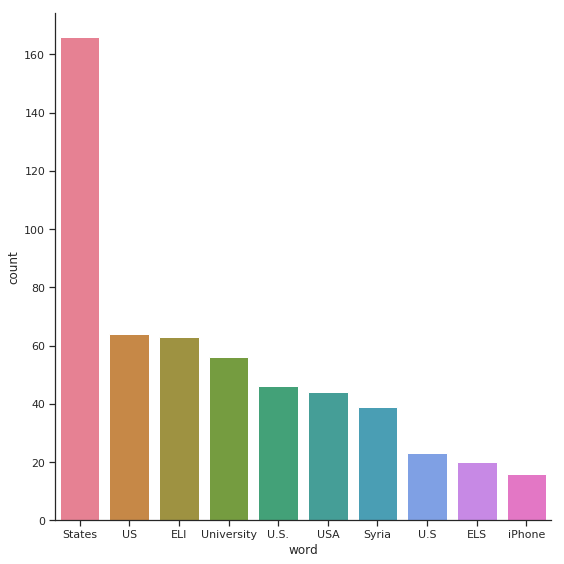

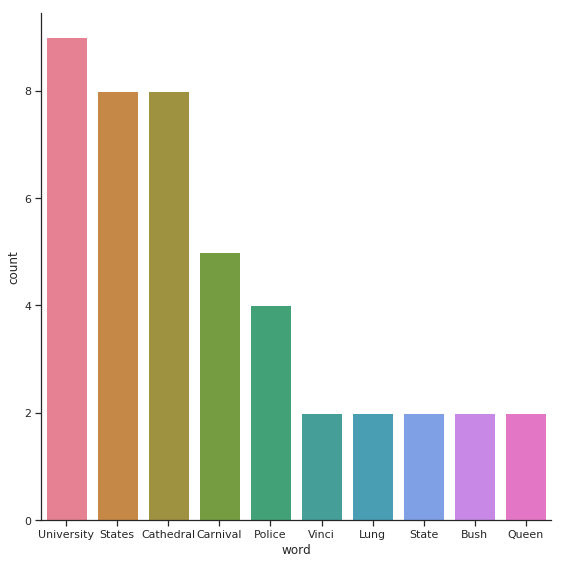

In [66]:
A5PrD = getCounter(arabic, 5, 'ProperSingDef', 'definite', 'Arabic L1, Level 5')
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=A5PrD.head(10), palette="husl", height=8)

S5PrD = getCounter(spanish, 5, 'ProperSingDef', 'definite', 'Spanish L1, Level 5')
g = sns.catplot(x= 'word', y="count", kind='bar',
                data=S5PrD.head(10), palette="husl", height=8)

<a id='conclusion'></a>
## Conclusion


Overall this has been an informative process! Both for my own coding efforts in various ways (python, visualization, and coding the different nominal features) and for the purpose of analysis.

#### Things achieved in this script


#### Limitations of this script